# Sentence Convergence w/ NLP

cosine similarity might be able to work best as the output metric to tell what idea is converging/diverging. Because it tracks the similarities between points of comparison.

But then checking the length of transcript for a particular person. Do we break it up by sentence. 
- What is considered that "smallest unit?"

# Setting up the files for analysis

## Idea 2 - Sentence Level Unit-ideas

(the main way how the excel file will be processed.)

Deletes the backchannel utterances (e.g. "okay", "yes", "right", "sounds good")

Splits up transcript by sentence by speaker

Couple of things done here:

1. Breaking the excel files' row into sentences

In the raw file, one "row" might be a short filler ("Yeah.") or a long paragraph with multiple ideas. That makes it hard to comapre ideas fairly. So we split each row into sentences. Now every chunk is about the same size, which makes our simililarity scores more meaningful.

2. Keeping the speaker

We always keep track of who said it. This way we can tell if an idea is picked up by someone-else (cross-speaker) or if the same person is just adding more details (same-speaker)

3. Tagging the type of sentence

We give each sentence a quick label like `Proposal/Offer`, `Acceptance`, `Question`, or `Inform/Report`. This is important because not every sentence is an "idea". For example, "Sounds good." is an acceptane, not a new idea. Tagging them stops these from messing up our idea similarity results, while still letting us track decisions.

4. Making the timeline cleans

Sometimes timestamps in the fiel go backwards or have ties. We fix this by nudging times forward by 0.001 seconds if needed. This tiny change doesn't affect the analysis, but it keeps our data in the right order.

### implementing co-similarity (SBERT)

all of this still tests the idea if Gemini is even capable of defining a convergence to solution, even if NLP topics are used within the transcript, based on all this code run?

In [ ]:
# === Fill missing sentence time estimates using JSON start/end times (authoritative) ===
import pandas as pd
import numpy as np
import json
from pathlib import Path

# --- CONFIG ---
sentences_path  = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/sentences_ABI_S15.csv"
utterances_path = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_ABI_S15_continuous_overwritten.csv"
json_path       = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/2021_05_21_ABI_S15.json"
out_path        = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/sentences_ABI_S15_filled.csv"

# --- Load ---
sents = pd.read_csv(sentences_path)
utts  = pd.read_csv(utterances_path)
with open(json_path, "r") as f:
    json_data = json.load(f)

# --- Helper: convert "MM:SS" or "HH:MM:SS" to seconds ---
def time_str_to_seconds(t_str: str) -> float:
    parts = [float(p) for p in str(t_str).split(":")]
    if len(parts) == 2:    # MM:SS
        return parts[0] * 60 + parts[1]
    elif len(parts) == 3:  # HH:MM:SS
        return parts[0] * 3600 + parts[1] * 60 + parts[2]
    else:
        raise ValueError(f"Unexpected time format: {t_str}")

# --- Build mapping from JSON index -> (start_sec, end_sec) using start_time/end_time ---
json_entries = json_data["all_data"]
json_times = {
    idx: (time_str_to_seconds(entry["start_time"]), time_str_to_seconds(entry["end_time"]))
    for idx, entry in enumerate(json_entries)
}

# --- Merge sentences with parent utterances (only index; avoid timestamp_x/y collisions) ---
utts = utts.copy()
utts["utter_row_idx"] = np.arange(len(utts), dtype=np.int64)

merged = sents.merge(
    utts[["utter_row_idx"]],  # minimal merge to group per-utterance
    left_on="source_row_index",
    right_on="utter_row_idx",
    how="left"
)

# --- Overwrite global start/end from JSON mapping (authoritative) ---
merged["global_start_sec_y"] = merged["source_row_index"].map(
    lambda i: json_times.get(int(i), (np.nan, np.nan))[0]
)
merged["global_end_sec_y"] = merged["source_row_index"].map(
    lambda i: json_times.get(int(i), (np.nan, np.nan))[1]
)

# --- Safe sentence-time imputation (prevents NaN dropouts) ---
for col in ["sent_start_sec_est", "sent_end_sec_est"]:
    if col not in df.columns:
        df[col] = pd.NA

if {"start_sec","end_sec"}.issubset(df.columns):
    df["sent_start_sec_est"] = df["sent_start_sec_est"].fillna(df["start_sec"])
    df["sent_end_sec_est"]   = df["sent_end_sec_est"].fillna(df["end_sec"])

# final fallback: if still missing, keep sentence inside its utterance window
mask = df["sent_start_sec_est"].isna() | df["sent_end_sec_est"].isna()
if mask.any() and {"start_sec","end_sec"}.issubset(df.columns):
    df.loc[mask, "sent_start_sec_est"] = df.loc[mask, "start_sec"]
    df.loc[mask, "sent_end_sec_est"]   = df.loc[mask, "end_sec"]


# --- Fill sentence start/end estimates evenly within each utterance's JSON span ---
def fill_group(g: pd.DataFrame) -> pd.DataFrame:
    start_parent = float(g["global_start_sec_y"].iloc[0])
    end_parent   = float(g["global_end_sec_y"].iloc[0])

    # Guard against missing or inverted spans
    if not np.isfinite(start_parent) or not np.isfinite(end_parent) or end_parent < start_parent:
        start_parent, end_parent = 0.0, 1e-6

    n = len(g)
    step = (end_parent - start_parent) / n if n > 0 else 0.0

    g = g.copy()
    g["sent_start_sec_est"] = [start_parent + i * step for i in range(n)]
    g["sent_end_sec_est"]   = [start_parent + (i + 1) * step for i in range(n)]
    return g

merged = merged.groupby("utter_row_idx", group_keys=False, dropna=False).apply(fill_group)

# --- Save ---
final = merged.drop(columns=["utter_row_idx"])
Path(out_path).parent.mkdir(parents=True, exist_ok=True)
final.to_csv(out_path, index=False)

print(f"Wrote: {out_path}")
print(f"Rows total: {len(final)}")
# Quick sanity peek
print(final[["source_row_index","global_start_sec_y","global_end_sec_y","sent_start_sec_est","sent_end_sec_est"]].head(8).to_string(index=False))


Wrote: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/sentences_ABI_S15_filled.csv
Rows total: 497
 source_row_index  global_start_sec_y  global_end_sec_y  sent_start_sec_est  sent_end_sec_est
                0                 0.0              37.0               0.000             4.625
                0                 0.0              37.0               4.625             9.250
                0                 0.0              37.0               9.250            13.875
                0                 0.0              37.0              13.875            18.500
                0                 0.0              37.0              18.500            23.125
                0                 0.0              37.0              23.125            27.750
                0                 0.0              37.0              27.750            32.375
                0                 0.0              37.0              32.375            37.000


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/271513283.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged = merged.groupby("utter_row_idx", group_keys=False, dropna=False).apply(fill_group)


using the utterance_data_ABI_S15_continuous_overwritten.csv

The `global_start_sec` works correctly even though it ends on the 58th minute approximately.

But somehow that's only the last of the transcripts pulled out?

I had checked across the JSON file of transcripts and that's the last one from EV's GitHub so this is all I can do for this part right now.

### breaking down into sentence as the "smallest unit"

The file that is in use now is `sentences_ABI_S15_filled.csv`

So now just working on the cosine similarity idea with the global time stamp and the sentences as the "smallest unit" from this point and below.

In [21]:
# === SBERT Convergence Pipeline: all-in-one cell =========================================
# - Loads sentence-level CSV
# - Imputes sentence times safely
# - Filters trivial sentences
# - Encodes with SBERT and forms local time-windowed pairs
# - Adds per-session similarity z-scores
# - Detects high-similarity "bursts" (candidate convergence)
# - Loads utterance annotations and overlays labels
# - Scores bursts with blended metric (labels + abs/rel similarity + speaker participation)
# - Extracts readable snippets
# - Applies progressive gates and writes a shortlist CSV + diagnostics
# ========================================================================================

import os, re, math
from pathlib import Path
import numpy as np
import pandas as pd

# ----------------------------- CONFIG (EDIT PATHS IF NEEDED) -----------------------------
IN_SENT_PATH = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/sentences_ABI_S15_filled.csv"
UTT_PATH     = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv"
OUT_DIR      = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs"

# Column names
SESSION_COL_PREFERRED = "session"          # will auto-resolve to 'global_session' if missing
SESSION_COL_ALT       = "global_session"
SPEAKER_COL           = "speaker"
TEXT_COL              = "sentence"
TIME_COL_START        = "sent_start_sec_est"
TIME_COL_END          = "sent_end_sec_est"

# SBERT model
SBERT_MODEL = "all-MiniLM-L6-v2"

# Pairing / burst params (lightly conservative defaults)
WINDOW_SEC          = 120.0   # time window to consider neighbor sentences for pairing (sec)
MIN_SIM_TO_KEEP     = 0.30    # drop very weak pairs
CONVERGE_SIM_HIGH   = 0.60    # threshold that feeds the burst detector
DIVERGE_SIM_LOW     = 0.40    # (kept for future use)
BURST_MERGE_GAP_SEC = 30.0    # merge adjacent strong pairs into a burst if centers within this gap
BURST_MIN_PAIRS     = 4
BURST_MIN_UNIQ_SPK  = 2
REQUIRE_CROSS_SPEAKER = True
LOOKAHEAD_SEC       = 90.0

# Trivial text filters
MIN_TOKENS = 3
MIN_CHARS  = 12
ALLOW_SHORT_IF_QUESTION = True
MIN_COMBINED_LEN_PAIR   = 20

# Progressive shortlist gates (strict -> relaxed)
GATES_LIST = [
    {"proxy_min": 0.20, "sim_min": 0.58, "pairs_min": 6, "spk_min": 3},  # strict
    {"proxy_min": 0.15, "sim_min": 0.55, "pairs_min": 5, "spk_min": 3},  # medium
    {"proxy_min": 0.10, "sim_min": 0.50, "pairs_min": 4, "spk_min": 2},  # lenient
    {"proxy_min": 0.00, "sim_min": 0.50, "pairs_min": 4, "spk_min": 2},  # fallback ignore label
]

# ----------------------------- HELPERS ---------------------------------------------------
def normalize_text(s: str) -> str:
    s = (s or "").strip()
    return re.sub(r"\s+", " ", s)

BACKCHANNELS = {
    "hi","hello","hey","ok","okay","yes","yeah","yep","no","right","cool","nice","thanks","thank you",
    "great","sure","uh-huh","mm-hmm","mhm","alright","k","yup","nope"
}
FILLER_START = re.compile(r"^(um|uh|erm|hmm|but|so|and|okay|ok)[\s,.;:!?-]*$", re.I)

def looks_trivial(s: str) -> bool:
    t = normalize_text(s)
    if not t:
        return True
    if len(t) < MIN_CHARS:
        if ALLOW_SHORT_IF_QUESTION and t.endswith("?"):
            return False
        toks = re.findall(r"\w+", t.lower())
        if len(toks) < MIN_TOKENS:
            return True
        if t.lower().strip("!?.:,;- ") in BACKCHANNELS:
            return True
        if FILLER_START.match(t.lower()):
            return True
    return False

def resolve_session_col(df, preferred=SESSION_COL_PREFERRED, alt=SESSION_COL_ALT, suffix=""):
    for c in (f"{preferred}{suffix}", f"{alt}{suffix}", preferred, alt):
        if c in df.columns:
            return c
    return None

def any_flag(row, cols):
    """OR across possible label columns that may be bool/0-1/strings."""
    vals = []
    for c in cols:
        if c in row and pd.notna(row[c]):
            v = row[c]
            if isinstance(v, (int, float, np.integer, np.floating)):
                vals.append(float(v) != 0.0)
            elif isinstance(v, str):
                vals.append(v.strip().lower() in {"true","1","yes","y"})
            else:
                vals.append(bool(v))
    return any(vals) if vals else False

def share(x):
    x = pd.Series(x).astype(bool)
    return float(x.mean()) if len(x) else 0.0

def normalize_speakers(u):  # 0..1 for 1..4+ speakers participating
    return float(np.clip((float(u) - 1.0) / 3.0, 0.0, 1.0))

# ----------------------------- LOAD SENTENCES + SAFE TIME IMPUTE -------------------------
sent = pd.read_csv(IN_SENT_PATH)
sess_col = resolve_session_col(sent)
if sess_col is None:
    raise ValueError("Could not resolve session column from sentences file.")

# Impute missing sentence times using utterance window if available
for col in [TIME_COL_START, TIME_COL_END]:
    if col not in sent.columns:
        sent[col] = pd.PandasArray([pd.NA] * len(sent))  # explicit NA col

# If utterance-level start/end exist, use them as fallback
if {"start_sec","end_sec"}.issubset(sent.columns):
    sent[TIME_COL_START] = pd.to_numeric(sent[TIME_COL_START], errors="coerce")
    sent[TIME_COL_END]   = pd.to_numeric(sent[TIME_COL_END], errors="coerce")
    sent[TIME_COL_START] = sent[TIME_COL_START].fillna(pd.to_numeric(sent["start_sec"], errors="coerce"))
    sent[TIME_COL_END]   = sent[TIME_COL_END].fillna(pd.to_numeric(sent["end_sec"], errors="coerce"))

# Final fallback: keep sentence inside utterance window if still NaN
mask_missing = sent[TIME_COL_START].isna() | sent[TIME_COL_END].isna()
if mask_missing.any() and {"start_sec","end_sec"}.issubset(sent.columns):
    sent.loc[mask_missing, TIME_COL_START] = pd.to_numeric(sent.loc[mask_missing, "start_sec"], errors="coerce")
    sent.loc[mask_missing, TIME_COL_END]   = pd.to_numeric(sent.loc[mask_missing, "end_sec"], errors="coerce")

# Compute midpoints and filter
sent = sent.copy()
sent["t_mid"] = (pd.to_numeric(sent[TIME_COL_START], errors="coerce").astype(float) +
                 pd.to_numeric(sent[TIME_COL_END],   errors="coerce").astype(float)) / 2.0
sent = sent[sent[TEXT_COL].astype(str).str.strip().ne("")]
sent = sent[np.isfinite(sent["t_mid"])].reset_index(drop=True)
sent["_rowid"] = np.arange(len(sent), dtype=np.int64)

# Trivial flags
sent["sentence_norm"] = sent[TEXT_COL].map(normalize_text)
sent["is_trivial"]    = sent["sentence_norm"].map(looks_trivial)

# Keep minimal copy for joins
sent_keep = sent[["_rowid", "source_row_index", sess_col, SPEAKER_COL, TEXT_COL, "t_mid", "is_trivial"]].copy()

print(f"Loaded sentences: {len(sent)} rows; session col = '{sess_col}'")

# ----------------------------- EMBEDDINGS (SBERT) ---------------------------------------
from sentence_transformers import SentenceTransformer
model = SentenceTransformer(SBERT_MODEL)
emb = model.encode(
    sent[TEXT_COL].tolist(), batch_size=64, show_progress_bar=True,
    convert_to_numpy=True, normalize_embeddings=True
)  # normalized => cosine = dot

# ----------------------------- BUILD PAIRS ----------------------------------------------
def compute_pairs_for_group(idx: np.ndarray) -> pd.DataFrame:
    times     = sent.loc[idx, "t_mid"].to_numpy()
    speakers  = sent.loc[idx, SPEAKER_COL].astype(str).to_numpy()
    trivial   = sent.loc[idx, "is_trivial"].to_numpy()
    lens      = sent.loc[idx, "sentence_norm"].str.len().to_numpy()
    E         = emb[idx]

    order = np.argsort(times)
    idx_sorted     = idx[order]
    times_sorted   = times[order]
    speakers_sorted= speakers[order]
    trivial_sorted = trivial[order]
    lens_sorted    = lens[order]
    E_sorted       = E[order]

    pairs = []
    n = len(idx_sorted)
    left = 0
    for right in range(n):
        t_r = times_sorted[right]
        while t_r - times_sorted[left] > WINDOW_SEC:
            left += 1
        lo = left
        hi = right + 1
        while hi < n and times_sorted[hi] - t_r <= WINDOW_SEC:
            hi += 1
        cand_idx = np.r_[np.arange(lo, right), np.arange(right + 1, hi)]
        if cand_idx.size == 0:
            continue

        sims = E_sorted[cand_idx].dot(E_sorted[right])
        keep_mask = sims >= MIN_SIM_TO_KEEP
        if not np.any(keep_mask):
            continue

        cand_idx = cand_idx[keep_mask]
        sims = sims[keep_mask]

        for k, jpos in enumerate(cand_idx):
            sp_i = speakers_sorted[right]; sp_j = speakers_sorted[jpos]
            if REQUIRE_CROSS_SPEAKER and (sp_i == sp_j):
                continue
            # skip trivial↔trivial and tiny content pairs
            if trivial_sorted[right] and trivial_sorted[jpos]:
                continue
            if (lens_sorted[right] + lens_sorted[jpos]) < MIN_COMBINED_LEN_PAIR:
                continue

            i_rowid = int(sent.loc[idx_sorted[right], "_rowid"])
            j_rowid = int(sent.loc[idx_sorted[jpos], "_rowid"])
            t_i = float(times_sorted[right]); t_j = float(times_sorted[jpos])
            t_c = 0.5 * (t_i + t_j)
            pairs.append((i_rowid, j_rowid, t_i, t_j, float(sims[k]), sp_i, sp_j, t_c))

    if not pairs:
        return pd.DataFrame(columns=["i_rowid","j_rowid","t_i","t_j","sim","speaker_i","speaker_j","t_center"])
    return pd.DataFrame(pairs, columns=["i_rowid","j_rowid","t_i","t_j","sim","speaker_i","speaker_j","t_center"])

pairs_dfs = []
for sess, g in sent.groupby(sess_col, sort=False):
    pg = compute_pairs_for_group(g.index.to_numpy())
    if len(pg):
        pg[sess_col] = sess
        pairs_dfs.append(pg)

pairs_df = pd.concat(pairs_dfs, axis=0, ignore_index=True) if pairs_dfs else pd.DataFrame(
    columns=["i_rowid","j_rowid","t_i","t_j","sim","speaker_i","speaker_j","t_center", sess_col]
)

# Dedup mirrored
if len(pairs_df):
    key = pairs_df.apply(lambda r: tuple(sorted((int(r["i_rowid"]), int(r["j_rowid"])))), axis=1)
    pairs_df = pairs_df[~key.duplicated()].reset_index(drop=True)

# Per-session similarity z-score
if len(pairs_df):
    pairs_df["sim_z"] = pairs_df.groupby(sess_col)["sim"].transform(
        lambda s: (s - s.mean()) / (s.std(ddof=0) + 1e-6)
    )
else:
    pairs_df["sim_z"] = np.nan

# ----------------------------- DETECT BURSTS --------------------------------------------
def detect_bursts(pairs_df: pd.DataFrame) -> pd.DataFrame:
    cols_out = [sess_col, "t_start", "t_end", "n_pairs", "uniq_speakers", "sim_max", "sim_mean", "example_pair"]
    if pairs_df is None or len(pairs_df) == 0:
        return pd.DataFrame(columns=cols_out)
    out = []
    for sess, g in pairs_df.groupby(sess_col, sort=False):
        g = g.sort_values("t_center").reset_index(drop=True)
        strong = g[g["sim"] >= CONVERGE_SIM_HIGH]
        if strong.empty:
            continue
        recs = strong[["t_center","sim","speaker_i","speaker_j","i_rowid","j_rowid"]].to_dict("records")
        cluster = [recs[0]]
        for rec in recs[1:]:
            if (float(rec["t_center"]) - float(cluster[-1]["t_center"])) <= BURST_MERGE_GAP_SEC:
                cluster.append(rec)
            else:
                if cluster:
                    dfc = pd.DataFrame(cluster)
                    uniq_spk = set(dfc["speaker_i"]).union(set(dfc["speaker_j"]))
                    if len(dfc) >= BURST_MIN_PAIRS and len(uniq_spk) >= BURST_MIN_UNIQ_SPK:
                        out.append({
                            sess_col: sess,
                            "t_start": float(dfc["t_center"].min()),
                            "t_end":   float(dfc["t_center"].max()),
                            "n_pairs": int(len(dfc)),
                            "uniq_speakers": int(len(uniq_spk)),
                            "sim_max": float(dfc["sim"].max()),
                            "sim_mean": float(dfc["sim"].mean()),
                            "example_pair": (
                                f'{sent.loc[int(dfc["i_rowid"].iloc[0]), TEXT_COL][:80]} … || '
                                f'{sent.loc[int(dfc["j_rowid"].iloc[0]), TEXT_COL][:80]} …'
                            ),
                        })
                cluster = [rec]
        if cluster:
            dfc = pd.DataFrame(cluster)
            uniq_spk = set(dfc["speaker_i"]).union(set(dfc["speaker_j"]))
            if len(dfc) >= BURST_MIN_PAIRS and len(uniq_spk) >= BURST_MIN_UNIQ_SPK:
                out.append({
                    sess_col: sess,
                    "t_start": float(dfc["t_center"].min()),
                    "t_end":   float(dfc["t_center"].max()),
                    "n_pairs": int(len(dfc)),
                    "uniq_speakers": int(len(uniq_spk)),
                    "sim_max": float(dfc["sim"].max()),
                    "sim_mean": float(dfc["sim"].mean()),
                    "example_pair": (
                        f'{sent.loc[int(dfc["i_rowid"].iloc[0]), TEXT_COL][:80]} … || '
                        f'{sent.loc[int(dfc["j_rowid"].iloc[0]), TEXT_COL][:80]} …'
                    ),
                })
    return pd.DataFrame(out, columns=cols_out).sort_values([sess_col, "t_start"]).reset_index(drop=True)

bursts_df = detect_bursts(pairs_df)

# ----------------------------- LOAD UTT ANNOTATIONS & OVERLAY ---------------------------
utts = pd.read_csv(UTT_PATH).reset_index().rename(columns={"index": "utter_row_idx"})
id_like = [c for c in ["utter_row_idx","speaker","session","global_session","timestamp"] if c in utts.columns]

# Heuristic pick label-like columns (customize keywords as needed)
label_like = [c for c in utts.columns if any(k in c.lower() for k in
                 ["decision","explanation","idea","agree","agreement","commit","consensus","proposal","accept"])]
utts_sub = utts[id_like + label_like].copy()

# Map pairs -> sentences (i/j) -> utter labels
pairs_i = pairs_df.merge(sent_keep.add_suffix("_i"), left_on="i_rowid", right_on="_rowid_i", how="left")
pairs_ij = pairs_i.merge(sent_keep.add_suffix("_j"), left_on="j_rowid", right_on="_rowid_j", how="left")

pairs_ij = pairs_ij.merge(utts_sub.add_suffix("_i"),
                          left_on="source_row_index_i", right_on="utter_row_idx_i", how="left"
                 ).merge(utts_sub.add_suffix("_j"),
                          left_on="source_row_index_j", right_on="utter_row_idx_j", how="left")

# Combined label flags
pairs_ij["has_label_i"]   = pairs_ij.apply(lambda r: any_flag(r, [f"{c}_i" for c in label_like]), axis=1)
pairs_ij["has_label_j"]   = pairs_ij.apply(lambda r: any_flag(r, [f"{c}_j" for c in label_like]), axis=1)
pairs_ij["has_label_any"] = pairs_ij["has_label_i"] | pairs_ij["has_label_j"]

# Optional: explicit decision/explanation shortcuts if exist
pairs_ij["decision_any"]    = False
pairs_ij["explanation_any"] = False
if "has_decision" in utts_sub.columns:
    pairs_ij["decision_any"] = pairs_ij.get("has_decision_i", False).fillna(0).astype(bool) | \
                               pairs_ij.get("has_decision_j", False).fillna(0).astype(bool)
if "has_explanation" in utts_sub.columns:
    pairs_ij["explanation_any"] = pairs_ij.get("has_explanation_i", False).fillna(0).astype(bool) | \
                                  pairs_ij.get("has_explanation_j", False).fillna(0).astype(bool)

# Attach burst indices to pairs
bursts_df = bursts_df.reset_index(drop=True).reset_index().rename(columns={"index": "burst_idx"})
sess_col_bursts = resolve_session_col(bursts_df)
sess_col_pairs  = resolve_session_col(pairs_ij, suffix="_i")
if sess_col_bursts is None or sess_col_pairs is None:
    raise ValueError("Could not resolve session columns for bursts/pairs.")

pairs_in_bursts_list = []
for sess_val, g_b in bursts_df.groupby(sess_col_bursts, sort=False):
    p = pairs_ij[pairs_ij[sess_col_pairs] == sess_val]
    if p.empty:
        continue
    for br in g_b.itertuples(index=False):
        m = (p["t_center"] >= br.t_start) & (p["t_center"] <= br.t_end)
        if m.any():
            tmp = p.loc[m].copy()
            tmp["burst_idx"] = br.burst_idx
            pairs_in_bursts_list.append(tmp)

pairs_in_bursts = pd.concat(pairs_in_bursts_list, ignore_index=True) if pairs_in_bursts_list else pairs_ij.iloc[0:0].copy()

# Summaries per burst (+ per-session normalized similarity)
if len(pairs_in_bursts):
    # uniq speakers across i/j
    spk_counts = (
        pd.concat([
            pairs_in_bursts[["burst_idx","speaker_i"]].rename(columns={"speaker_i":"speaker"}),
            pairs_in_bursts[["burst_idx","speaker_j"]].rename(columns={"speaker_j":"speaker"})
        ], ignore_index=True)
        .dropna()
        .drop_duplicates()
        .groupby("burst_idx")["speaker"].nunique()
        .rename("uniq_speakers_both")
        .reset_index()
    )

    agg = pairs_in_bursts.groupby("burst_idx").agg(
        n_pairs=("sim","size"),
        mean_sim=("sim","mean"),
        median_sim=("sim","median"),
        mean_sim_z=("sim_z","mean") if "sim_z" in pairs_in_bursts.columns else ("sim","mean"),
        frac_any_label=("has_label_any", share),
        frac_decision=("decision_any", share) if "decision_any" in pairs_in_bursts.columns else ("has_label_any", share),
        frac_explanation=("explanation_any", share) if "explanation_any" in pairs_in_bursts.columns else ("has_label_any", share),
    ).reset_index()

    burst_summ = agg.merge(spk_counts, on="burst_idx", how="left")
else:
    burst_summ = pd.DataFrame(columns=["burst_idx","n_pairs","mean_sim","median_sim","mean_sim_z",
                                       "frac_any_label","frac_decision","frac_explanation","uniq_speakers_both"])

# Bring timing/context back in
bursts_labeled = bursts_df.merge(burst_summ, on="burst_idx", how="left")

# ----------------------------- HARMONIZE MERGE COLUMNS (fixes KeyError: 'n_pairs') -------
def coalesce_cols(df, out_name, candidates, default=np.nan):
    """Create df[out_name] by taking the first non-null across candidate columns (in order)."""
    existing = [c for c in candidates if c in df.columns]
    if not existing:
        df[out_name] = default
        return df
    tmp = df[existing].copy()
    df[out_name] = tmp.bfill(axis=1).iloc[:, 0]
    return df

# 1) n_pairs: prefer agg version; fallback to other variants or derive from pairs_in_bursts
bursts_labeled = coalesce_cols(
    bursts_labeled,
    "n_pairs",
    ["n_pairs", "n_pairs_y", "n_pairs_x"],
    default=np.nan
)
if bursts_labeled["n_pairs"].isna().any():
    if "burst_idx" in pairs_in_bursts.columns and len(pairs_in_bursts):
        derived = (pairs_in_bursts.groupby("burst_idx").size()
                   .rename("n_pairs").reset_index())
        bursts_labeled = bursts_labeled.drop(columns=["n_pairs"]).merge(
            derived, on="burst_idx", how="left"
        )
    bursts_labeled["n_pairs"] = bursts_labeled["n_pairs"].fillna(0)

# 2) mean_sim: prefer 'mean_sim'; else coalesce from sim_mean variants
bursts_labeled = coalesce_cols(
    bursts_labeled,
    "mean_sim",
    ["mean_sim", "mean_sim_y", "mean_sim_x", "sim_mean_y", "sim_mean_x", "sim_mean"],
    default=np.nan
)
bursts_labeled["mean_sim"] = pd.to_numeric(bursts_labeled["mean_sim"], errors="coerce").fillna(0.0)

# 3) mean_sim_z: if missing, set to 0
if "mean_sim_z" not in bursts_labeled.columns:
    bursts_labeled["mean_sim_z"] = 0.0
bursts_labeled["mean_sim_z"] = pd.to_numeric(bursts_labeled["mean_sim_z"], errors="coerce").fillna(0.0)

# 4) uniq_speakers_both: fall back to 'uniq_speakers' if needed
if "uniq_speakers_both" not in bursts_labeled.columns:
    bursts_labeled = coalesce_cols(
        bursts_labeled,
        "uniq_speakers_both",
        ["uniq_speakers_both", "uniq_speakers_y", "uniq_speakers_x", "uniq_speakers"],
        default=np.nan
    )
bursts_labeled["uniq_speakers_both"] = pd.to_numeric(
    bursts_labeled["uniq_speakers_both"], errors="coerce"
).fillna(pd.to_numeric(bursts_labeled.get("uniq_speakers", 0), errors="coerce")).fillna(0).astype(int)

# 5) label fractions: ensure present with safe defaults
for c in ["frac_any_label","frac_decision","frac_explanation"]:
    if c not in bursts_labeled.columns:
        bursts_labeled[c] = np.nan
    bursts_labeled[c] = pd.to_numeric(bursts_labeled[c], errors="coerce")

# Optional: clean merge artifacts
drop_artifacts = [c for c in bursts_labeled.columns if re.search(r"(_x|_y)$", c)]
if drop_artifacts:
    bursts_labeled = bursts_labeled.drop(columns=drop_artifacts)

# ----------------------------- SCORING ---------------------------------------------------
def pick_proxy_label(df):
    for c in ["frac_decision", "frac_explanation", "frac_any_label"]:
        if c in df.columns and df[c].fillna(0).gt(0).any():
            return c
    return None

proxy_col = pick_proxy_label(bursts_labeled)
bursts_labeled["proxy_label"] = bursts_labeled[proxy_col].fillna(0.0) if proxy_col else 0.0

w_label, w_sim_abs, w_sim_rel, w_spk = 0.45, 0.35, 0.10, 0.10
bursts_labeled["conv_score"] = (
    w_label   * bursts_labeled["proxy_label"].fillna(0.0) +
    w_sim_abs * bursts_labeled["mean_sim"].fillna(0.0) +
    w_sim_rel * bursts_labeled["mean_sim_z"].fillna(0.0) +
    w_spk     * bursts_labeled["uniq_speakers_both"].fillna(0).map(normalize_speakers)
)

# ----------------------------- SNIPPETS FOR REVIEW --------------------------------------
def extract_snippet(row, df_source, max_chars=700, max_lines=12):
    start, end = row["t_start"], row["t_end"]
    seg = df_source[(df_source["t_mid"] >= start) & (df_source["t_mid"] <= end)]
    if seg.empty and {TIME_COL_START, TIME_COL_END}.issubset(df_source.columns):
        seg = df_source[(df_source[TIME_COL_START] <= end) & (df_source[TIME_COL_END] >= start)]
    lines = []
    seg = seg.sort_values("t_mid")
    for _, r in seg.iterrows():
        t = int(r.get("t_mid", 0))
        sp = r.get(SPEAKER_COL, "?")
        tx = str(r.get(TEXT_COL, "")).strip()
        if not tx:
            continue
        lines.append(f"[{t:>5}s] {sp}: {tx}")
        if len(lines) >= max_lines:
            break
    snippet = "\n".join(lines)
    if len(snippet) > max_chars:
        snippet = snippet[:max_chars] + " …"
    return snippet

if len(bursts_labeled):
    bursts_labeled = bursts_labeled.copy()
    bursts_labeled["snippet"] = bursts_labeled.apply(lambda r: extract_snippet(r, df_source=sent), axis=1)

# ----------------------------- PROGRESSIVE GATES & SHORTLIST ----------------------------
candidates = []
for gates in GATES_LIST:
    m = (
        (bursts_labeled["proxy_label"]                  >= gates["proxy_min"]) &
        (bursts_labeled["mean_sim"].fillna(0.0)         >= gates["sim_min"]) &
        (bursts_labeled["n_pairs"].fillna(0)            >= gates["pairs_min"]) &
        (bursts_labeled["uniq_speakers_both"].fillna(0) >= gates["spk_min"])
    )
    sub = bursts_labeled[m].copy().sort_values(["conv_score","mean_sim"], ascending=False)
    if len(sub):
        candidates = sub
        print("Selected gate:", gates)
        break

if len(candidates) == 0:
    candidates = bursts_labeled.copy().sort_values(["conv_score","mean_sim"], ascending=False).head(10)
    print("No rows passed gates. Showing top 10 by conv_score for manual review.")

# ----------------------------- SAVE ARTIFACTS & DIAGNOSTICS -----------------------------
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
pairs_path            = os.path.join(OUT_DIR, "sbert_pairs_kept.csv")
bursts_path           = os.path.join(OUT_DIR, "sbert_convergence_bursts.csv")
pairs_with_labels     = os.path.join(OUT_DIR, "pairs_with_labels.csv")
bursts_with_labels    = os.path.join(OUT_DIR, "bursts_with_labels.csv")
shortlist_path        = os.path.join(OUT_DIR, "convergence_shortlist.csv")

pairs_df.to_csv(pairs_path, index=False)
bursts_df.to_csv(bursts_path, index=False)
pairs_in_bursts.to_csv(pairs_with_labels, index=False)
bursts_labeled.to_csv(bursts_with_labels, index=False)
candidates.to_csv(shortlist_path, index=False)

print(f"\n✓ Saved PAIRS  -> {pairs_path} (rows={len(pairs_df)})")
print(f"✓ Saved BURSTS -> {bursts_path} (rows={len(bursts_df)})")
print(f"✓ Saved OVERLAY pairs -> {pairs_with_labels} (rows={len(pairs_in_bursts)})")
print(f"✓ Saved OVERLAY bursts -> {bursts_with_labels} (rows={len(bursts_labeled)})")
print(f"✓ Saved SHORTLIST -> {shortlist_path} (rows={len(candidates)})")

cols_show = [c for c in ["burst_idx", sess_col, "t_start", "t_end", "conv_score", "proxy_label", "mean_sim",
                         "n_pairs","uniq_speakers_both","frac_decision","frac_explanation","frac_any_label","example_pair"]
             if c in candidates.columns]
print("\nShortlist preview:")
print(candidates[cols_show].head(12).to_string(index=False))
# ========================================================================================


Loaded sentences: 497 rows; session col = 'session'


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 8/8 [00:00<00:00, 84.43it/s]
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/2977063502.py:397: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[out_name] = tmp.bfill(axis=1).iloc[:, 0]
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/2977063502.py:397: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) in

Selected gate: {'proxy_min': 0.0, 'sim_min': 0.5, 'pairs_min': 4, 'spk_min': 2}

✓ Saved PAIRS  -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sbert_pairs_kept.csv (rows=661)
✓ Saved BURSTS -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sbert_convergence_bursts.csv (rows=3)
✓ Saved OVERLAY pairs -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/pairs_with_labels.csv (rows=0)
✓ Saved OVERLAY bursts -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/bursts_with_labels.csv (rows=3)
✓ Saved SHORTLIST -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_shortlist.csv (rows=3)

Shortlist preview:
 burst_idx            session    t_start       t_end  conv_score  proxy_label  mean_sim  n_pairs  uniq_speakers_both  frac_decision  frac_explanation  frac_any_label                                                                                                                 

In [22]:
# === SBERT Convergence Pipeline: all-in-one cell =========================================
# Uses your uploaded files in /mnt/data and writes outputs to /mnt/data/Outputs
# ========================================================================================

import os, re, math
from pathlib import Path
import numpy as np
import pandas as pd

# ----------------------------- CONFIG (EDIT ONLY IF NEEDED) ------------------------------
IN_SENT_PATH = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/sentences_ABI_S15.csv"
UTT_PATH     = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv"
OUT_DIR      = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs"   # outputs will be written here

# Column names
SESSION_COL_PREFERRED = "session"          # will auto-resolve to 'global_session' if missing
SESSION_COL_ALT       = "global_session"
SPEAKER_COL           = "speaker"
TEXT_COL              = "sentence"
TIME_COL_START        = "sent_start_sec_est"
TIME_COL_END          = "sent_end_sec_est"

# SBERT model
SBERT_MODEL = "all-MiniLM-L6-v2"

# Pairing / burst params
WINDOW_SEC          = 120.0
MIN_SIM_TO_KEEP     = 0.30
CONVERGE_SIM_HIGH   = 0.60
DIVERGE_SIM_LOW     = 0.40
BURST_MERGE_GAP_SEC = 30.0
BURST_MIN_PAIRS     = 4
BURST_MIN_UNIQ_SPK  = 2
REQUIRE_CROSS_SPEAKER = True
LOOKAHEAD_SEC       = 90.0

# Trivial text filters
MIN_TOKENS = 3
MIN_CHARS  = 12
ALLOW_SHORT_IF_QUESTION = True
MIN_COMBINED_LEN_PAIR   = 20

# Progressive shortlist gates (strict -> relaxed)
GATES_LIST = [
    {"proxy_min": 0.20, "sim_min": 0.58, "pairs_min": 6, "spk_min": 3},
    {"proxy_min": 0.15, "sim_min": 0.55, "pairs_min": 5, "spk_min": 3},
    {"proxy_min": 0.10, "sim_min": 0.50, "pairs_min": 4, "spk_min": 2},
    {"proxy_min": 0.00, "sim_min": 0.50, "pairs_min": 4, "spk_min": 2},
]

# ----------------------------- HELPERS ---------------------------------------------------
def normalize_text(s: str) -> str:
    s = (s or "").strip()
    return re.sub(r"\s+", " ", s)

BACKCHANNELS = {
    "hi","hello","hey","ok","okay","yes","yeah","yep","no","right","cool","nice","thanks","thank you",
    "great","sure","uh-huh","mm-hmm","mhm","alright","k","yup","nope"
}
FILLER_START = re.compile(r"^(um|uh|erm|hmm|but|so|and|okay|ok)[\s,.;:!?-]*$", re.I)

def looks_trivial(s: str) -> bool:
    t = normalize_text(s)
    if not t:
        return True
    if len(t) < MIN_CHARS:
        if ALLOW_SHORT_IF_QUESTION and t.endswith("?"):
            return False
        toks = re.findall(r"\w+", t.lower())
        if len(toks) < MIN_TOKENS:
            return True
        if t.lower().strip("!?.:,;- ") in BACKCHANNELS:
            return True
        if FILLER_START.match(t.lower()):
            return True
    return False

def resolve_session_col(df, preferred=SESSION_COL_PREFERRED, alt=SESSION_COL_ALT, suffix=""):
    for c in (f"{preferred}{suffix}", f"{alt}{suffix}", preferred, alt):
        if c in df.columns:
            return c
    return None

def any_flag(row, cols):
    vals = []
    for c in cols:
        if c in row and pd.notna(row[c]):
            v = row[c]
            if isinstance(v, (int, float, np.integer, np.floating)):
                vals.append(float(v) != 0.0)
            elif isinstance(v, str):
                vals.append(v.strip().lower() in {"true","1","yes","y"})
            else:
                vals.append(bool(v))
    return any(vals) if vals else False

def share(x):
    x = pd.Series(x).astype(bool)
    return float(x.mean()) if len(x) else 0.0

def normalize_speakers(u):  # 0..1 for 1..4+ speakers
    return float(np.clip((float(u) - 1.0) / 3.0, 0.0, 1.0))

# ----------------------------- LOAD SENTENCES + SAFE TIME IMPUTE -------------------------
sent = pd.read_csv(IN_SENT_PATH)
sess_col = resolve_session_col(sent)
if sess_col is None:
    raise ValueError("Could not resolve session column from sentences file.")

for col in [TIME_COL_START, TIME_COL_END]:
    if col not in sent.columns:
        sent[col] = pd.PandasArray([pd.NA] * len(sent))

if {"start_sec","end_sec"}.issubset(sent.columns):
    sent[TIME_COL_START] = pd.to_numeric(sent[TIME_COL_START], errors="coerce")
    sent[TIME_COL_END]   = pd.to_numeric(sent[TIME_COL_END], errors="coerce")
    sent[TIME_COL_START] = sent[TIME_COL_START].fillna(pd.to_numeric(sent["start_sec"], errors="coerce"))
    sent[TIME_COL_END]   = sent[TIME_COL_END].fillna(pd.to_numeric(sent["end_sec"], errors="coerce"))

mask_missing = sent[TIME_COL_START].isna() | sent[TIME_COL_END].isna()
if mask_missing.any() and {"start_sec","end_sec"}.issubset(sent.columns):
    sent.loc[mask_missing, TIME_COL_START] = pd.to_numeric(sent.loc[mask_missing, "start_sec"], errors="coerce")
    sent.loc[mask_missing, TIME_COL_END]   = pd.to_numeric(sent.loc[mask_missing, "end_sec"], errors="coerce")

sent = sent.copy()
sent["t_mid"] = (pd.to_numeric(sent[TIME_COL_START], errors="coerce").astype(float) +
                 pd.to_numeric(sent[TIME_COL_END],   errors="coerce").astype(float)) / 2.0
sent = sent[sent[TEXT_COL].astype(str).str.strip().ne("")]
sent = sent[np.isfinite(sent["t_mid"])].reset_index(drop=True)
sent["_rowid"] = np.arange(len(sent), dtype=np.int64)

sent["sentence_norm"] = sent[TEXT_COL].map(normalize_text)
sent["is_trivial"]    = sent["sentence_norm"].map(looks_trivial)

sent_keep = sent[["_rowid", "source_row_index", sess_col, SPEAKER_COL, TEXT_COL, "t_mid", "is_trivial"]].copy()
print(f"Loaded sentences: {len(sent)} rows; session col = '{sess_col}'")

# ----------------------------- EMBEDDINGS (SBERT) ---------------------------------------
from sentence_transformers import SentenceTransformer
model = SentenceTransformer(SBERT_MODEL)
emb = model.encode(
    sent[TEXT_COL].tolist(), batch_size=64, show_progress_bar=True,
    convert_to_numpy=True, normalize_embeddings=True
)

# ----------------------------- BUILD PAIRS ----------------------------------------------
def compute_pairs_for_group(idx: np.ndarray) -> pd.DataFrame:
    times     = sent.loc[idx, "t_mid"].to_numpy()
    speakers  = sent.loc[idx, SPEAKER_COL].astype(str).to_numpy()
    trivial   = sent.loc[idx, "is_trivial"].to_numpy()
    lens      = sent.loc[idx, "sentence_norm"].str.len().to_numpy()
    E         = emb[idx]

    order = np.argsort(times)
    idx_sorted     = idx[order]
    times_sorted   = times[order]
    speakers_sorted= speakers[order]
    trivial_sorted = trivial[order]
    lens_sorted    = lens[order]
    E_sorted       = E[order]

    pairs = []
    n = len(idx_sorted)
    left = 0
    for right in range(n):
        t_r = times_sorted[right]
        while t_r - times_sorted[left] > WINDOW_SEC:
            left += 1
        lo = left
        hi = right + 1
        while hi < n and times_sorted[hi] - t_r <= WINDOW_SEC:
            hi += 1
        cand_idx = np.r_[np.arange(lo, right), np.arange(right + 1, hi)]
        if cand_idx.size == 0:
            continue

        sims = E_sorted[cand_idx].dot(E_sorted[right])
        keep_mask = sims >= MIN_SIM_TO_KEEP
        if not np.any(keep_mask):
            continue

        cand_idx = cand_idx[keep_mask]
        sims = sims[keep_mask]

        for k, jpos in enumerate(cand_idx):
            sp_i = speakers_sorted[right]; sp_j = speakers_sorted[jpos]
            if REQUIRE_CROSS_SPEAKER and (sp_i == sp_j):
                continue
            if trivial_sorted[right] and trivial_sorted[jpos]:
                continue
            if (lens_sorted[right] + lens_sorted[jpos]) < MIN_COMBINED_LEN_PAIR:
                continue

            i_rowid = int(sent.loc[idx_sorted[right], "_rowid"])
            j_rowid = int(sent.loc[idx_sorted[jpos], "_rowid"])
            t_i = float(times_sorted[right]); t_j = float(times_sorted[jpos])
            t_c = 0.5 * (t_i + t_j)
            pairs.append((i_rowid, j_rowid, t_i, t_j, float(sims[k]), sp_i, sp_j, t_c))

    if not pairs:
        return pd.DataFrame(columns=["i_rowid","j_rowid","t_i","t_j","sim","speaker_i","speaker_j","t_center"])
    return pd.DataFrame(pairs, columns=["i_rowid","j_rowid","t_i","t_j","sim","speaker_i","speaker_j","t_center"])

pairs_dfs = []
for sess, g in sent.groupby(sess_col, sort=False):
    pg = compute_pairs_for_group(g.index.to_numpy())
    if len(pg):
        pg[sess_col] = sess
        pairs_dfs.append(pg)

pairs_df = pd.concat(pairs_dfs, axis=0, ignore_index=True) if pairs_dfs else pd.DataFrame(
    columns=["i_rowid","j_rowid","t_i","t_j","sim","speaker_i","speaker_j","t_center", sess_col]
)

if len(pairs_df):
    key = pairs_df.apply(lambda r: tuple(sorted((int(r["i_rowid"]), int(r["j_rowid"])))), axis=1)
    pairs_df = pairs_df[~key.duplicated()].reset_index(drop=True)

if len(pairs_df):
    pairs_df["sim_z"] = pairs_df.groupby(sess_col)["sim"].transform(
        lambda s: (s - s.mean()) / (s.std(ddof=0) + 1e-6)
    )
else:
    pairs_df["sim_z"] = np.nan

# ----------------------------- DETECT BURSTS --------------------------------------------
def detect_bursts(pairs_df: pd.DataFrame) -> pd.DataFrame:
    cols_out = [sess_col, "t_start", "t_end", "n_pairs", "uniq_speakers", "sim_max", "sim_mean", "example_pair"]
    if pairs_df is None or len(pairs_df) == 0:
        return pd.DataFrame(columns=cols_out)
    out = []
    for sess, g in pairs_df.groupby(sess_col, sort=False):
        g = g.sort_values("t_center").reset_index(drop=True)
        strong = g[g["sim"] >= CONVERGE_SIM_HIGH]
        if strong.empty:
            continue
        recs = strong[["t_center","sim","speaker_i","speaker_j","i_rowid","j_rowid"]].to_dict("records")
        cluster = [recs[0]]
        for rec in recs[1:]:
            if (float(rec["t_center"]) - float(cluster[-1]["t_center"])) <= BURST_MERGE_GAP_SEC:
                cluster.append(rec)
            else:
                if cluster:
                    dfc = pd.DataFrame(cluster)
                    uniq_spk = set(dfc["speaker_i"]).union(set(dfc["speaker_j"]))
                    if len(dfc) >= BURST_MIN_PAIRS and len(uniq_spk) >= BURST_MIN_UNIQ_SPK:
                        out.append({
                            sess_col: sess,
                            "t_start": float(dfc["t_center"].min()),
                            "t_end":   float(dfc["t_center"].max()),
                            "n_pairs": int(len(dfc)),
                            "uniq_speakers": int(len(uniq_spk)),
                            "sim_max": float(dfc["sim"].max()),
                            "sim_mean": float(dfc["sim"].mean()),
                            "example_pair": (
                                f'{sent.loc[int(dfc["i_rowid"].iloc[0]), TEXT_COL][:80]} … || '
                                f'{sent.loc[int(dfc["j_rowid"].iloc[0]), TEXT_COL][:80]} …'
                            ),
                        })
                cluster = [rec]
        if cluster:
            dfc = pd.DataFrame(cluster)
            uniq_spk = set(dfc["speaker_i"]).union(set(dfc["speaker_j"]))
            if len(dfc) >= BURST_MIN_PAIRS and len(uniq_spk) >= BURST_MIN_UNIQ_SPK:
                out.append({
                    sess_col: sess,
                    "t_start": float(dfc["t_center"].min()),
                    "t_end":   float(dfc["t_center"].max()),
                    "n_pairs": int(len(dfc)),
                    "uniq_speakers": int(len(uniq_spk)),
                    "sim_max": float(dfc["sim"].max()),
                    "sim_mean": float(dfc["sim"].mean()),
                    "example_pair": (
                        f'{sent.loc[int(dfc["i_rowid"].iloc[0]), TEXT_COL][:80]} … || '
                        f'{sent.loc[int(dfc["j_rowid"].iloc[0]), TEXT_COL][:80]} …'
                    ),
                })
    return pd.DataFrame(out, columns=cols_out).sort_values([sess_col, "t_start"]).reset_index(drop=True)

bursts_df = detect_bursts(pairs_df)

# ----------------------------- LOAD UTT ANNOTATIONS & OVERLAY ---------------------------
utts = pd.read_csv(UTT_PATH).reset_index().rename(columns={"index": "utter_row_idx"})
id_like = [c for c in ["utter_row_idx","speaker","session","global_session","timestamp"] if c in utts.columns]

label_like = [c for c in utts.columns if any(k in c.lower() for k in
                 ["decision","explanation","idea","agree","agreement","commit","consensus","proposal","accept"])]
utts_sub = utts[id_like + label_like].copy()

pairs_i = pairs_df.merge(sent_keep.add_suffix("_i"), left_on="i_rowid", right_on="_rowid_i", how="left")
pairs_ij = pairs_i.merge(sent_keep.add_suffix("_j"), left_on="j_rowid", right_on="_rowid_j", how="left")

pairs_ij = pairs_ij.merge(utts_sub.add_suffix("_i"),
                          left_on="source_row_index_i", right_on="utter_row_idx_i", how="left"
                 ).merge(utts_sub.add_suffix("_j"),
                          left_on="source_row_index_j", right_on="utter_row_idx_j", how="left")

pairs_ij["has_label_i"]   = pairs_ij.apply(lambda r: any_flag(r, [f"{c}_i" for c in label_like]), axis=1)
pairs_ij["has_label_j"]   = pairs_ij.apply(lambda r: any_flag(r, [f"{c}_j" for c in label_like]), axis=1)
pairs_ij["has_label_any"] = pairs_ij["has_label_i"] | pairs_ij["has_label_j"]

pairs_ij["decision_any"]    = False
pairs_ij["explanation_any"] = False
if "has_decision" in utts_sub.columns:
    pairs_ij["decision_any"] = pairs_ij.get("has_decision_i", False).fillna(0).astype(bool) | \
                               pairs_ij.get("has_decision_j", False).fillna(0).astype(bool)
if "has_explanation" in utts_sub.columns:
    pairs_ij["explanation_any"] = pairs_ij.get("has_explanation_i", False).fillna(0).astype(bool) | \
                                  pairs_ij.get("has_explanation_j", False).fillna(0).astype(bool)

# Attach burst indices to pairs
bursts_df = bursts_df.reset_index(drop=True).reset_index().rename(columns={"index": "burst_idx"})
sess_col_bursts = resolve_session_col(bursts_df)
sess_col_pairs  = resolve_session_col(pairs_ij, suffix="_i")
if sess_col_bursts is None or sess_col_pairs is None:
    raise ValueError("Could not resolve session columns for bursts/pairs.")

pairs_in_bursts_list = []
for sess_val, g_b in bursts_df.groupby(sess_col_bursts, sort=False):
    p = pairs_ij[pairs_ij[sess_col_pairs] == sess_val]
    if p.empty:
        continue
    for br in g_b.itertuples(index=False):
        m = (p["t_center"] >= br.t_start) & (p["t_center"] <= br.t_end)
        if m.any():
            tmp = p.loc[m].copy()
            tmp["burst_idx"] = br.burst_idx
            pairs_in_bursts_list.append(tmp)

pairs_in_bursts = pd.concat(pairs_in_bursts_list, ignore_index=True) if pairs_in_bursts_list else pairs_ij.iloc[0:0].copy()

# Summaries per burst (+ per-session normalized similarity)
if len(pairs_in_bursts):
    spk_counts = (
        pd.concat([
            pairs_in_bursts[["burst_idx","speaker_i"]].rename(columns={"speaker_i":"speaker"}),
            pairs_in_bursts[["burst_idx","speaker_j"]].rename(columns={"speaker_j":"speaker"})
        ], ignore_index=True)
        .dropna()
        .drop_duplicates()
        .groupby("burst_idx")["speaker"].nunique()
        .rename("uniq_speakers_both")
        .reset_index()
    )

    agg = pairs_in_bursts.groupby("burst_idx").agg(
        n_pairs=("sim","size"),
        mean_sim=("sim","mean"),
        median_sim=("sim","median"),
        mean_sim_z=("sim_z","mean") if "sim_z" in pairs_in_bursts.columns else ("sim","mean"),
        frac_any_label=("has_label_any", share),
        frac_decision=("decision_any", share) if "decision_any" in pairs_in_bursts.columns else ("has_label_any", share),
        frac_explanation=("explanation_any", share) if "explanation_any" in pairs_in_bursts.columns else ("has_label_any", share),
    ).reset_index()

    burst_summ = agg.merge(spk_counts, on="burst_idx", how="left")
else:
    burst_summ = pd.DataFrame(columns=["burst_idx","n_pairs","mean_sim","median_sim","mean_sim_z",
                                       "frac_any_label","frac_decision","frac_explanation","uniq_speakers_both"])

# Bring timing/context back in
bursts_labeled = bursts_df.merge(burst_summ, on="burst_idx", how="left")

# ----------------------------- HARMONIZE MERGE COLUMNS ----------------------------------
def coalesce_cols(df, out_name, candidates, default=np.nan):
    existing = [c for c in candidates if c in df.columns]
    if not existing:
        df[out_name] = default
        return df
    tmp = df[existing].copy()
    df[out_name] = tmp.bfill(axis=1).iloc[:, 0]
    return df

# n_pairs
bursts_labeled = coalesce_cols(bursts_labeled, "n_pairs", ["n_pairs","n_pairs_y","n_pairs_x"], default=np.nan)
if bursts_labeled["n_pairs"].isna().any():
    if "burst_idx" in pairs_in_bursts.columns and len(pairs_in_bursts):
        derived = (pairs_in_bursts.groupby("burst_idx").size().rename("n_pairs").reset_index())
        bursts_labeled = bursts_labeled.drop(columns=["n_pairs"]).merge(derived, on="burst_idx", how="left")
    bursts_labeled["n_pairs"] = bursts_labeled["n_pairs"].fillna(0)

# mean_sim
bursts_labeled = coalesce_cols(bursts_labeled, "mean_sim",
                               ["mean_sim","mean_sim_y","mean_sim_x","sim_mean_y","sim_mean_x","sim_mean"], default=np.nan)
bursts_labeled["mean_sim"] = pd.to_numeric(bursts_labeled["mean_sim"], errors="coerce").fillna(0.0)

# mean_sim_z
if "mean_sim_z" not in bursts_labeled.columns:
    bursts_labeled["mean_sim_z"] = 0.0
bursts_labeled["mean_sim_z"] = pd.to_numeric(bursts_labeled["mean_sim_z"], errors="coerce").fillna(0.0)

# uniq_speakers_both
if "uniq_speakers_both" not in bursts_labeled.columns:
    bursts_labeled = coalesce_cols(bursts_labeled, "uniq_speakers_both",
                                   ["uniq_speakers_both","uniq_speakers_y","uniq_speakers_x","uniq_speakers"], default=np.nan)
bursts_labeled["uniq_speakers_both"] = pd.to_numeric(bursts_labeled["uniq_speakers_both"], errors="coerce") \
    .fillna(pd.to_numeric(bursts_labeled.get("uniq_speakers", 0), errors="coerce")) \
    .fillna(0).astype(int)

# label fractions
for c in ["frac_any_label","frac_decision","frac_explanation"]:
    if c not in bursts_labeled.columns:
        bursts_labeled[c] = np.nan
    bursts_labeled[c] = pd.to_numeric(bursts_labeled[c], errors="coerce")

# Drop *_x/*_y noise
artifacts = [c for c in bursts_labeled.columns if re.search(r"(_x|_y)$", c)]
if artifacts:
    bursts_labeled = bursts_labeled.drop(columns=artifacts)

# ----------------------------- SCORING ---------------------------------------------------
def pick_proxy_label(df):
    for c in ["frac_decision", "frac_explanation", "frac_any_label"]:
        if c in df.columns and df[c].fillna(0).gt(0).any():
            return c
    return None

proxy_col = pick_proxy_label(bursts_labeled)
bursts_labeled["proxy_label"] = bursts_labeled[proxy_col].fillna(0.0) if proxy_col else 0.0

w_label, w_sim_abs, w_sim_rel, w_spk = 0.45, 0.35, 0.10, 0.10
bursts_labeled["conv_score"] = (
    w_label   * bursts_labeled["proxy_label"].fillna(0.0) +
    w_sim_abs * bursts_labeled["mean_sim"].fillna(0.0) +
    w_sim_rel * bursts_labeled["mean_sim_z"].fillna(0.0) +
    w_spk     * bursts_labeled["uniq_speakers_both"].fillna(0).map(normalize_speakers)
)

# ----------------------------- SNIPPETS FOR REVIEW --------------------------------------
def extract_snippet(row, df_source, max_chars=700, max_lines=12):
    start, end = row["t_start"], row["t_end"]
    seg = df_source[(df_source["t_mid"] >= start) & (df_source["t_mid"] <= end)]
    if seg.empty and {TIME_COL_START, TIME_COL_END}.issubset(df_source.columns):
        seg = df_source[(df_source[TIME_COL_START] <= end) & (df_source[TIME_COL_END] >= start)]
    lines = []
    seg = seg.sort_values("t_mid")
    for _, r in seg.iterrows():
        t = int(r.get("t_mid", 0))
        sp = r.get(SPEAKER_COL, "?")
        tx = str(r.get(TEXT_COL, "")).strip()
        if not tx:
            continue
        lines.append(f"[{t:>5}s] {sp}: {tx}")
        if len(lines) >= max_lines:
            break
    snippet = "\n".join(lines)
    if len(snippet) > max_chars:
        snippet = snippet[:max_chars] + " …"
    return snippet

if len(bursts_labeled):
    bursts_labeled = bursts_labeled.copy()
    bursts_labeled["snippet"] = bursts_labeled.apply(lambda r: extract_snippet(r, df_source=sent), axis=1)

# ----------------------------- PROGRESSIVE GATES & SHORTLIST ----------------------------
candidates = []
for gates in GATES_LIST:
    m = (
        (bursts_labeled["proxy_label"]                  >= gates["proxy_min"]) &
        (bursts_labeled["mean_sim"].fillna(0.0)         >= gates["sim_min"]) &
        (bursts_labeled["n_pairs"].fillna(0)            >= gates["pairs_min"]) &
        (bursts_labeled["uniq_speakers_both"].fillna(0) >= gates["spk_min"])
    )
    sub = bursts_labeled[m].copy().sort_values(["conv_score","mean_sim"], ascending=False)
    if len(sub):
        candidates = sub
        print("Selected gate:", gates)
        break

if len(candidates) == 0:
    candidates = bursts_labeled.copy().sort_values(["conv_score","mean_sim"], ascending=False).head(10)
    print("No rows passed gates. Showing top 10 by conv_score for manual review.")

# ----------------------------- SAVE ARTIFACTS & DIAGNOSTICS -----------------------------
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
pairs_path            = os.path.join(OUT_DIR, "sbert_pairs_kept.csv")
bursts_path           = os.path.join(OUT_DIR, "sbert_convergence_bursts.csv")
pairs_with_labels     = os.path.join(OUT_DIR, "pairs_with_labels.csv")
bursts_with_labels    = os.path.join(OUT_DIR, "bursts_with_labels.csv")
shortlist_path        = os.path.join(OUT_DIR, "convergence_shortlist.csv")

pairs_df.to_csv(pairs_path, index=False)
bursts_df.to_csv(bursts_path, index=False)
pairs_in_bursts.to_csv(pairs_with_labels, index=False)
bursts_labeled.to_csv(bursts_with_labels, index=False)
candidates.to_csv(shortlist_path, index=False)

print(f"\n✓ Saved PAIRS  -> {pairs_path} (rows={len(pairs_df)})")
print(f"✓ Saved BURSTS -> {bursts_path} (rows={len(bursts_df)})")
print(f"✓ Saved OVERLAY pairs -> {pairs_with_labels} (rows={len(pairs_in_bursts)})")
print(f"✓ Saved OVERLAY bursts -> {bursts_with_labels} (rows={len(bursts_labeled)})")
print(f"✓ Saved SHORTLIST -> {shortlist_path} (rows={len(candidates)})")

cols_show = [c for c in ["burst_idx", sess_col, "t_start", "t_end", "conv_score", "proxy_label", "mean_sim",
                         "n_pairs","uniq_speakers_both","frac_decision","frac_explanation","frac_any_label","example_pair"]
             if c in candidates.columns]
print("\nShortlist preview:")
print(candidates[cols_show].head(12).to_string(index=False))
# ========================================================================================


Loaded sentences: 457 rows; session col = 'session'


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 8/8 [00:00<00:00, 27.19it/s]


Selected gate: {'proxy_min': 0.0, 'sim_min': 0.5, 'pairs_min': 4, 'spk_min': 2}

✓ Saved PAIRS  -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sbert_pairs_kept.csv (rows=628)
✓ Saved BURSTS -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sbert_convergence_bursts.csv (rows=2)
✓ Saved OVERLAY pairs -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/pairs_with_labels.csv (rows=0)
✓ Saved OVERLAY bursts -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/bursts_with_labels.csv (rows=2)
✓ Saved SHORTLIST -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_shortlist.csv (rows=2)

Shortlist preview:
 burst_idx            session    t_start       t_end  conv_score  proxy_label  mean_sim  n_pairs  uniq_speakers_both  frac_decision  frac_explanation  frac_any_label                                                                                                                 

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/424973820.py:371: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[out_name] = tmp.bfill(axis=1).iloc[:, 0]
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/424973820.py:371: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[out_name] = tmp.bfill(axis=1).iloc[:, 0]


In [25]:
# === Multi-Lens Idea Convergence (for ABI_S15 ~66 min) ==================================
# Builds 3 segmentations (sentence / speaker-block / clause-ish), runs SBERT,
# extracts top-k similar & different pairs, prepares semantic timeline + network CSVs.
# Outputs: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/{sentence,blocks,clauses}/...
# ========================================================================================

import os, re, math
from pathlib import Path
from typing import Tuple
import numpy as np
import pandas as pd

# -------------------------- CONFIG -------------------------------------------------------
IN_SENT_PATH = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/sentences_ABI_S15.csv"
SESSION_FILTER = None  # e.g., "ABI_S15" or None to auto-pick the dominant session in file

# Model & similarity window
SBERT_MODEL = "all-MiniLM-L6-v2"
WINDOW_SEC  = 120.0       # time neighborhood for candidate comparisons
TOPK_SIM    = 100         # number of most similar pairs to keep per lens (global)
TOPK_DIFF   = 100         # number of most different pairs to keep per lens (global)
MIN_LEN_CH  = 12          # drop ultra-short units unless question
MIN_TOKS    = 3
ALLOW_Q     = True
BLOCK_MAX_CHARS = 320     # speaker-blocks: cap merged text around this size
BLOCK_MAX_SEC   = 30.0    # speaker-blocks: also stop merging if span exceeds this
CLAUSE_MIN_CHARS = 20     # clause-ish: keep only reasonably substantive pieces

# Output
ROOT_OUT = Path("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs")
ROOT_OUT.mkdir(parents=True, exist_ok=True)

# -------------------------- HELPERS ------------------------------------------------------
def normalize_text(s: str) -> str:
    s = (s or "").strip()
    return re.sub(r"\s+", " ", s)

BACKCHANNELS = {
    "hi","hello","hey","ok","okay","yes","yeah","yep","no","right","cool","nice","thanks","thank you",
    "great","sure","uh-huh","mm-hmm","mhm","alright","k","yup","nope"
}
FILLER_START = re.compile(r"^(um|uh|erm|hmm|but|so|and|okay|ok)[\s,.;:!?-]*$", re.I)

def looks_trivial(s: str) -> bool:
    t = normalize_text(s)
    if not t: return True
    if len(t) < MIN_LEN_CH:
        if ALLOW_Q and t.endswith("?"): return False
        toks = re.findall(r"\w+", t.lower())
        if len(toks) < MIN_TOKS: return True
        if t.lower().strip("!?.:,;- ") in BACKCHANNELS: return True
        if FILLER_START.match(t.lower()): return True
    return False

def resolve_session_col(df, preferred="session", alt="global_session"):
    for c in (preferred, alt):
        if c in df.columns: return c
    return None

# -------------------------- LOAD SENTENCES ----------------------------------------------
sent = pd.read_csv(IN_SENT_PATH)
sess_col = resolve_session_col(sent)
if sess_col is None:
    raise ValueError("Need a session column ('session' or 'global_session').")

# compute midpoints
time_start = "sent_start_sec_est" if "sent_start_sec_est" in sent.columns else ("start_sec" if "start_sec" in sent.columns else None)
time_end   = "sent_end_sec_est"   if "sent_end_sec_est"   in sent.columns else ("end_sec"   if "end_sec"   in sent.columns else None)
if not time_start or not time_end:
    raise ValueError("Need sentence start/end columns: sent_start_sec_est/sent_end_sec_est (or start_sec/end_sec).")

sent["t_start"] = pd.to_numeric(sent[time_start], errors="coerce").astype(float)
sent["t_end"]   = pd.to_numeric(sent[time_end],   errors="coerce").astype(float)
sent["t_mid"]   = (sent["t_start"] + sent["t_end"]) / 2.0

# choose session (dominant if not specified)
if SESSION_FILTER is None:
    SESSION_FILTER = sent[sess_col].value_counts().idxmax()
sent = sent[sent[sess_col] == SESSION_FILTER].copy().reset_index(drop=True)

# basic cleaning
sent["sentence_norm"] = sent["sentence"].astype(str).map(normalize_text)
sent = sent[(~sent["sentence_norm"].map(looks_trivial)) & np.isfinite(sent["t_mid"])].copy()
sent["sid"] = np.arange(len(sent), dtype=np.int64)   # <- use 'sid' (no leading underscore)

print(f"Session: {SESSION_FILTER} | sentences kept: {len(sent)}")

# -------------------------- SEGMENTATION LENSES -----------------------------------------
# 1) Sentence lens
sentence_lens = sent[["sid","t_start","t_end","t_mid",sess_col,"speaker","sentence_norm"]].rename(
    columns={"sid":"unit_id","sentence_norm":"text"}
).copy()
sentence_lens["lens"] = "sentence"

# 2) Speaker-blocks lens: merge consecutive sentences from same speaker within caps
blocks = []
if len(sent):
    cur_spk = None; cur_ids=[]; cur_txt=[]; cur_t0=None; cur_t1=None
    for r in sent.itertuples(index=False):
        spk = r.speaker; txt = r.sentence_norm; s = r.t_start; e = r.t_end
        if (cur_spk is None) or (spk != cur_spk) or \
           (cur_txt and (len(" ".join(cur_txt)) + len(txt) > BLOCK_MAX_CHARS)) or \
           (cur_t0 is not None and (e - cur_t0) > BLOCK_MAX_SEC):
            # flush
            if cur_spk is not None and cur_txt:
                blocks.append((tuple(cur_ids), cur_spk, cur_t0, cur_t1, " ".join(cur_txt)))
            # reset
            cur_spk = spk; cur_ids=[r.sid]; cur_txt=[txt]; cur_t0=s; cur_t1=e
        else:
            cur_ids.append(r.sid); cur_txt.append(txt); cur_t1 = e
    if cur_spk is not None and cur_txt:
        blocks.append((tuple(cur_ids), cur_spk, cur_t0, cur_t1, " ".join(cur_txt)))

blocks_lens = pd.DataFrame(blocks, columns=["source_ids","speaker","t_start","t_end","text"])
blocks_lens["t_mid"] = 0.5*(blocks_lens["t_start"]+blocks_lens["t_end"])
blocks_lens["unit_id"] = np.arange(len(blocks_lens), dtype=np.int64)
blocks_lens["lens"] = "blocks"
print(f"Speaker-blocks: {len(blocks_lens)} units")

# 3) Clause-ish lens: try spaCy; fallback to sentences
try:
    import spacy
    try:
        nlp = spacy.load("en_core_web_sm")
    except Exception:
        nlp = spacy.blank("en")
        nlp.add_pipe("sentencizer")
    clause_rows = []
    for r in sent.itertuples(index=False):
        txt = r.sentence_norm
        doc = nlp(txt)
        # use sentence spans or punctuation splits as proxy for clauses
        spans = [s.text.strip() for s in doc.sents] if len(list(doc.sents)) else re.split(r"[;:—\-–]", txt)
        spans = [s for s in spans if len(s.strip()) >= CLAUSE_MIN_CHARS]
        if not spans:
            continue
        # spread times proportionally by char length
        total = sum(len(s) for s in spans)
        acc = r.t_start
        for s_txt in spans:
            frac = len(s_txt)/total if total>0 else 1.0/len(spans)
            dur = (r.t_end - r.t_start)*frac if np.isfinite(r.t_end - r.t_start) else 0
            t0 = acc; t1 = acc + dur; acc = t1
            clause_rows.append((r.sid, r.speaker, t0, t1, 0.5*(t0+t1), s_txt))
    clauses_lens = pd.DataFrame(clause_rows, columns=["source_id","speaker","t_start","t_end","t_mid","text"])
    clauses_lens["unit_id"] = np.arange(len(clauses_lens), dtype=np.int64)
    clauses_lens["lens"] = "clauses"
except Exception as e:
    print(f"[warn] spaCy not available or failed: {e} — using sentence lens for 'clauses'")
    clauses_lens = sentence_lens.copy()
    clauses_lens["lens"] = "clauses"
print(f"Clauses-ish: {len(clauses_lens)} units")

# -------------------------- EMBEDDINGS ---------------------------------------------------
from sentence_transformers import SentenceTransformer
model = SentenceTransformer(SBERT_MODEL)

def embed_df(df: pd.DataFrame) -> np.ndarray:
    txts = df["text"].astype(str).tolist()
    return model.encode(txts, batch_size=64, show_progress_bar=True,
                        convert_to_numpy=True, normalize_embeddings=True)

E_sentence = embed_df(sentence_lens)
E_blocks   = embed_df(blocks_lens)   if len(blocks_lens)   else np.zeros((0,384))
E_clauses  = embed_df(clauses_lens)  if len(clauses_lens)  else np.zeros((0,384))

# -------------------------- SIMILAR / DIFFERENT PAIRS -----------------------------------
def top_pairs(df_units: pd.DataFrame, E: np.ndarray, topk_sim=TOPK_SIM, topk_diff=TOPK_DIFF,
              window_sec=WINDOW_SEC) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      - pairs_all (within time window)
      - top_sim (global top-k by similarity)
      - top_diff (global top-k by low similarity)
      - timeline (per-unit best similarity vs time)
    """
    if len(df_units) == 0 or E.shape[0] == 0:
        empty = pd.DataFrame(columns=["u_i","u_j","t_i","t_j","sim","speaker_i","speaker_j"])
        return empty, empty, empty, pd.DataFrame(columns=["u","t","speaker","best_sim"])

    t = df_units["t_mid"].to_numpy()
    spk = df_units["speaker"].astype(str).to_numpy()
    order = np.argsort(t)
    t = t[order]; spk = spk[order]; E = E[order]
    ids = df_units["unit_id"].to_numpy()[order]

    rows = []
    left = 0
    n = len(ids)
    for right in range(n):
        tr = t[right]
        while tr - t[left] > window_sec:
            left += 1
        lo = left
        hi = right + 1
        while hi < n and t[hi] - tr <= window_sec:
            hi += 1
        cand = np.r_[np.arange(lo, right), np.arange(right+1, hi)]
        if cand.size == 0:
            continue
        sims = E[cand].dot(E[right])
        for k, jpos in enumerate(cand):
            rows.append((int(ids[right]), int(ids[jpos]),
                         float(t[right]), float(t[jpos]),
                         float(sims[k]), spk[right], spk[jpos]))

    pairs_all = pd.DataFrame(rows, columns=["u_i","u_j","t_i","t_j","sim","speaker_i","speaker_j"])
    if len(pairs_all) == 0:
        return pairs_all, pairs_all, pairs_all, pd.DataFrame(columns=["u","t","speaker","best_sim"])

    # Remove duplicated undirected edges (keep u_i < u_j)
    key = pairs_all.apply(lambda r: tuple(sorted((int(r["u_i"]), int(r["u_j"])))), axis=1)
    pairs_all = pairs_all.loc[~key.duplicated()].reset_index(drop=True)

    # Top similar / different
    top_sim_df  = pairs_all.sort_values("sim", ascending=False).head(topk_sim).copy()
    top_diff_df = pairs_all.sort_values("sim", ascending=True ).head(topk_diff).copy()

    # Timeline: best similarity per unit
    best_sim = pairs_all.groupby("u_i")["sim"].max().rename("best_sim").reset_index()
    timeline = df_units[["unit_id","t_mid","speaker"]].merge(
        best_sim, left_on="unit_id", right_on="u_i", how="left"
    ).drop(columns=["u_i"]).rename(columns={"unit_id":"u","t_mid":"t"})

    return pairs_all, top_sim_df, top_diff_df, timeline

# Compute for each lens
pairs_s_all, pairs_s_top, pairs_s_diff, timeline_s = top_pairs(sentence_lens, E_sentence)
pairs_b_all, pairs_b_top, pairs_b_diff, timeline_b = top_pairs(blocks_lens,   E_blocks)
pairs_c_all, pairs_c_top, pairs_c_diff, timeline_c = top_pairs(clauses_lens,  E_clauses)

# -------------------------- NETWORK EXPORTS ----------------------------------------------
def write_lens_exports(name: str, units: pd.DataFrame, pairs_all: pd.DataFrame,
                       top_sim: pd.DataFrame, top_diff: pd.DataFrame, timeline: pd.DataFrame):
    out = ROOT_OUT / name
    out.mkdir(parents=True, exist_ok=True)

    # Nodes
    nodes = units[["unit_id","t_mid","t_start","t_end","speaker","text"]].copy()
    nodes = nodes.rename(columns={"unit_id":"id","t_mid":"t"})
    nodes.to_csv(out / "nodes.csv", index=False)

    # Edges (all within window)
    edges_all = pairs_all.rename(columns={"u_i":"source","u_j":"target","sim":"weight"})
    edges_all.to_csv(out / "edges_all.csv", index=False)

    # Edges top similar/different
    edges_sim = top_sim.rename(columns={"u_i":"source","u_j":"target","sim":"weight"})
    edges_diff = top_diff.rename(columns={"u_i":"source","u_j":"target","sim":"weight"})
    edges_sim.to_csv(out / "edges_top_similar.csv", index=False)
    edges_diff.to_csv(out / "edges_top_different.csv", index=False)

    # Timeline
    timeline.to_csv(out / "timeline.csv", index=False)

    # Convenience: a compact “pairs preview”
    prev_cols = ["source","target","weight"]
    edges_sim[prev_cols].head(25).to_csv(out / "preview_top_similar_head25.csv", index=False)
    edges_diff[prev_cols].head(25).to_csv(out / "preview_top_different_head25.csv", index=False)

write_lens_exports("sentence", sentence_lens, pairs_s_all, pairs_s_top, pairs_s_diff, timeline_s)
write_lens_exports("blocks",   blocks_lens,   pairs_b_all, pairs_b_top, pairs_b_diff, timeline_b)
write_lens_exports("clauses",  clauses_lens,  pairs_c_all, pairs_c_top, pairs_c_diff, timeline_c)

print("\n✓ Wrote multi-lens exports here:")
print(f"  {ROOT_OUT}/sentence/*")
print(f"  {ROOT_OUT}/blocks/*")
print(f"  {ROOT_OUT}/clauses/*")

# --------- What to look at next (for Evey-ready visuals) --------------------------------
# - sentence/nodes.csv + edges_top_similar.csv: import to Gephi or a simple D3/pyvis graph
#   (nodes colored by speaker; edge width by 'weight' = cosine similarity)
# - sentence/timeline.csv: plot t vs best_sim and overlay your convergence bursts if desired
# - blocks/* and clauses/*: compare how segmentation changes clusters and divergence spots
# ========================================================================================


Session: 2021_05_21_ABI_S15 | sentences kept: 434
Speaker-blocks: 220 units
[warn] spaCy not available or failed: No module named 'spacy' — using sentence lens for 'clauses'
Clauses-ish: 434 units


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 7/7 [00:00<00:00, 86.74it/s]



✓ Wrote multi-lens exports here:
  /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sentence/*
  /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/blocks/*
  /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/clauses/*


# Combining Sentences, Blocks, Clauses into One

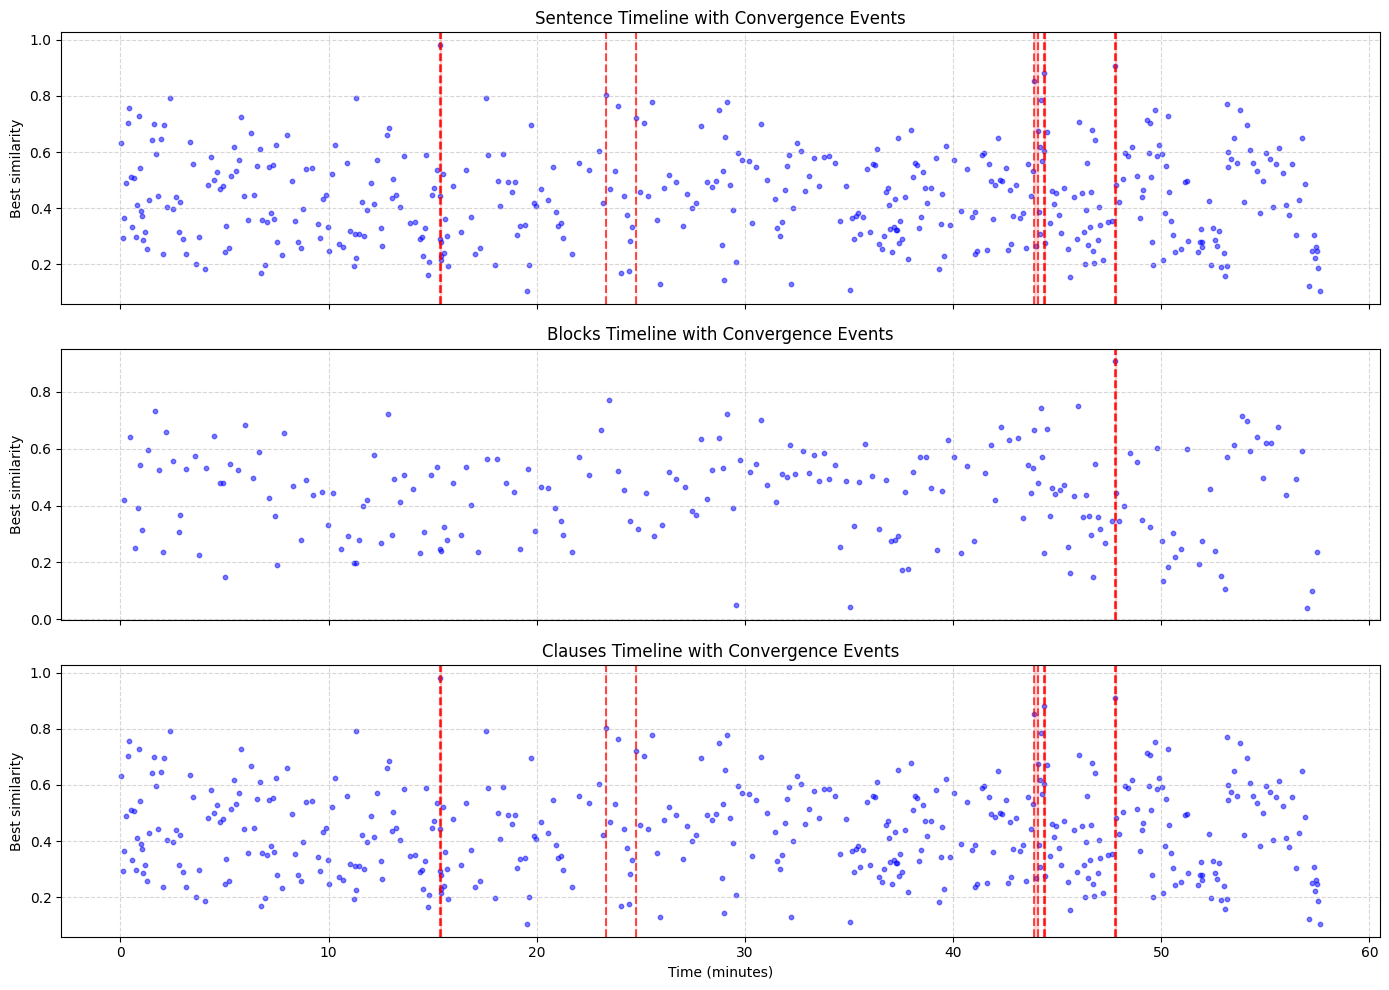

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Settings
utterance_path = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv"
sim_threshold = 0.8
burst_gap_sec = 10  # max gap between events in a burst

# Load master utterance data (not used for plotting yet, but available for future annotation filtering)
df_utter = pd.read_csv(utterance_path)

lens_paths = {
    "Sentence": "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sentence",
    "Blocks": "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/blocks",
    "Clauses": "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/clauses"
}

fig, axes = plt.subplots(len(lens_paths), 1, figsize=(14, 10), sharex=True)
if len(lens_paths) == 1:
    axes = [axes]

for ax, (lens_name, folder) in zip(axes, lens_paths.items()):
    # Load timeline + edges
    timeline_path = os.path.join(folder, "timeline.csv")
    edges_path = os.path.join(folder, "edges_top_similar.csv")

    df_t = pd.read_csv(timeline_path)
    df_edges = pd.read_csv(edges_path)

    # Convert 't' from seconds to minutes
    df_t['t_min'] = df_t['t'] / 60

    # Scatter plot of all units
    ax.scatter(df_t['t_min'], df_t['best_sim'], color='blue', s=10, alpha=0.5, label='All units')

    # High-similarity edges using 'weight' column
    high_sim_edges = df_edges[df_edges['weight'] >= sim_threshold]

    # Map 'source' and 'target' unit IDs to times (in minutes)
    unit_time_map_min = df_t.set_index('u')['t_min'].to_dict()
    event_times = []
    for _, row in high_sim_edges.iterrows():
        if row['source'] in unit_time_map_min:
            event_times.append(unit_time_map_min[row['source']])
        if row['target'] in unit_time_map_min:
            event_times.append(unit_time_map_min[row['target']])
    event_times = sorted(set(event_times))

    # Plot vertical lines for each event
    for t_event in event_times:
        ax.axvline(t_event, color='red', linestyle='--', alpha=0.7)

    # Detect bursts for shaded regions (still in minutes)
    bursts = []
    if event_times:
        start = event_times[0]
        prev = start
        for t in event_times[1:]:
            if (t - prev) * 60 <= burst_gap_sec:  # convert back to seconds for gap check
                prev = t
            else:
                bursts.append((start, prev))
                start = t
                prev = t
        bursts.append((start, prev))

    # Plot shaded regions for bursts
    for start, end in bursts:
        ax.axvspan(start, end, color='red', alpha=0.15)

    ax.set_title(f"{lens_name} Timeline with Convergence Events")
    ax.set_ylabel("Best similarity")
    ax.grid(True, linestyle='--', alpha=0.5)

axes[-1].set_xlabel("Time (minutes)")
plt.tight_layout()
plt.show()


Graph is produced for ABI_S15, next section is confirming it against the transcript for the types of convergences.

A convergence is considered as:

people saying semantically similar things in quick succession

near a coded decision / explanation / new idea

collapsed into an event burst so you're not coutning every line as separate

### Confirming convergence red lines against the transcript

In [54]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

# ---------------- Settings ----------------
SESSION_VAL           = "2021_05_21_ABI_S15"
SIM_THRESHOLD         = 0.80      # similarity cutoff to flag an edge
PAIR_MAX_SEP_SEC      = 45.0      # |t_i - t_j| must be <= this to be a live exchange
EVENT_MERGE_GAP_SEC   = 8.0       # merge events whose centers are closer than this
JOIN_TOL_SEC          = 5.0       # fuzzy join tolerance to utterances on global time
CTX_WIN_SEC           = 15.0      # context window (± seconds) used to count speakers
ROUND_TO_HALF         = True

UTTER_PATH = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv"
LENS_DIRS  = {
    "Sentence": "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sentence",
    "Blocks":   "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/blocks",
    "Clauses":  "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/clauses",
}
OUT_DIR    = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs"
OUT_ALL    = os.path.join(OUT_DIR, "convergence_events_verified.csv")
OUT_TRUE   = os.path.join(OUT_DIR, "convergence_events_TRUE.csv")

# -------------- Helpers -------------------
def round_half_sec(x: pd.Series) -> pd.Series:
    return (np.round(pd.to_numeric(x, errors="coerce") * 2) / 2.0)

def pick_edges_weight(df_edges: pd.DataFrame) -> str:
    if "weight" in df_edges.columns: return "weight"
    if "sim"    in df_edges.columns: return "sim"
    raise ValueError("edges_top_similar.csv needs a 'weight' or 'sim' column.")

def detect_bursts(ts, gap=10.0):
    ts = sorted(float(x) for x in ts)
    out = []
    if not ts: return out
    start = prev = ts[0]
    for t in ts[1:]:
        if t - prev <= gap: prev = t
        else:
            out.append((start, prev))
            start = prev = t
    out.append((start, prev))
    return out

# -------------- Load utterances + prep --------------
u = pd.read_csv(UTTER_PATH)
assert "session" in u.columns, "Expected 'session' in utterance file."
assert "global_timestamp_sec" in u.columns, "Need 'global_timestamp_sec' for global alignment."

u = u[u["session"] == SESSION_VAL].copy()
if u.empty:
    u = u[u["session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()
    if u.empty:
        raise ValueError(f"No utterance rows matched session '{SESSION_VAL}'.")

time_col = "start_sec_adjusted" if "start_sec_adjusted" in u.columns and u["start_sec_adjusted"].notna().any() else "start_sec"
u[time_col] = round_half_sec(u[time_col])
u["global_timestamp_sec"] = round_half_sec(u["global_timestamp_sec"])

# ---------------- Compute global offset from Sentence anchor ----------------
sent_t = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "timeline.csv"))
sent_e = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "edges_top_similar.csv"))
sent_t["t"] = round_half_sec(sent_t["t"])
wcol = pick_edges_weight(sent_e)

hi = sent_e[sent_e[wcol] >= SIM_THRESHOLD]
anchor_times_local = (
    sent_t.set_index("u").reindex(hi["source"])["t"]
    .dropna().sort_values().tolist()
)
if anchor_times_local:
    t_anchor = float(anchor_times_local[0])
    j = (u[time_col] - t_anchor).abs().idxmin()
    offset_sec = float(u.loc[j, "global_timestamp_sec"] - u.loc[j, time_col])
else:
    offset_sec = float(np.median(u["global_timestamp_sec"] - u[time_col]))

meta_cols = [c for c in ["speaker","annotations","has_decision","has_explanation","has_new_idea","transcript"] if c in u.columns]
u_small = u[["global_timestamp_sec", time_col] + meta_cols].sort_values("global_timestamp_sec").copy()

# ---------------- Gather events across lenses (edge-based, cross-speaker, close in time) ----------------
records = []
for lens, folder in LENS_DIRS.items():
    t_path = os.path.join(folder, "timeline.csv")
    e_path = os.path.join(folder, "edges_top_similar.csv")
    n_path = os.path.join(folder, "nodes.csv")

    if not (os.path.exists(t_path) and os.path.exists(e_path) and os.path.exists(n_path)):
        continue

    df_t = pd.read_csv(t_path)
    df_e = pd.read_csv(e_path)
    df_n = pd.read_csv(n_path).rename(columns={"id":"unit_id"})

    # Normalize times (local + global)
    df_t["t"] = round_half_sec(df_t["t"])
    df_t["t_global"] = df_t["t"] + offset_sec
    if ROUND_TO_HALF: df_t["t_global"] = round_half_sec(df_t["t_global"])

    # Filter edges by similarity
    wcol = pick_edges_weight(df_e)
    df_e = df_e[df_e[wcol] >= SIM_THRESHOLD].copy()
    if df_e.empty:
        continue

    # Ensure we have times & speakers for both ends; fallback if missing
    have_ij_times = {"t_i","t_j"}.issubset(df_e.columns)
    have_ij_spk   = {"speaker_i","speaker_j"}.issubset(df_e.columns)

    if not have_ij_times:
        # map from unit -> time using timeline
        u2t = df_t.set_index("u")["t"].to_dict()
        df_e["t_i"] = df_e["source"].map(u2t)
        df_e["t_j"] = df_e["target"].map(u2t)

    if not have_ij_spk:
        # map from unit -> speaker using nodes
        u2spk = df_n.set_index("unit_id")["speaker"].to_dict() if "speaker" in df_n.columns else {}
        df_e["speaker_i"] = df_e["source"].map(u2spk)
        df_e["speaker_j"] = df_e["target"].map(u2spk)

    # Globalize both ends and keep cross-speaker, close-in-time edges
    df_e["t_i_g"] = round_half_sec(df_e["t_i"] + offset_sec)
    df_e["t_j_g"] = round_half_sec(df_e["t_j"] + offset_sec)
    df_e["pair_sep_sec"] = (df_e["t_i_g"] - df_e["t_j_g"]).abs()

    cross_speaker = df_e["speaker_i"].astype(str) != df_e["speaker_j"].astype(str)
    close_in_time = df_e["pair_sep_sec"] <= PAIR_MAX_SEP_SEC
    df_e = df_e[cross_speaker & close_in_time].copy()
    if df_e.empty:
        continue

    # Represent each kept edge as an "event" centered at the midpoint time
    df_e["event_center_g"] = round_half_sec((df_e["t_i_g"] + df_e["t_j_g"]) / 2.0)
    df_e["event_start_g"]  = df_e[["t_i_g","t_j_g"]].min(axis=1)
    df_e["event_end_g"]    = df_e[["t_i_g","t_j_g"]].max(axis=1)

    # Merge nearby events into bursts (per lens)
    centers = df_e["event_center_g"].tolist()
    bursts = detect_bursts(centers, gap=EVENT_MERGE_GAP_SEC)

    # For each burst, pick the strongest edge as the representative center + carry speakers/text
    for (bstart, bend) in bursts:
        in_burst = df_e[(df_e["event_center_g"] >= bstart) & (df_e["event_center_g"] <= bend)]
        if in_burst.empty: 
            continue
        rep = in_burst.sort_values(wcol, ascending=False).iloc[0]

        # Attach node text from the nearer endpoint to the center
        # nearest unit to rep['event_center_g']
        t_center = float(rep["event_center_g"])
        # find nearest endpoint unit id
        cand_units = [
            (int(rep["source"]), float(rep["t_i_g"])),
            (int(rep["target"]), float(rep["t_j_g"]))
        ]
        unit_id_center = min(cand_units, key=lambda x: abs(x[1]-t_center))[0]

        node_text = None; node_speaker = None
        rowN = df_n[df_n["unit_id"] == unit_id_center]
        if not rowN.empty:
            node_text    = str(rowN.iloc[0].get("text", ""))
            node_speaker = rowN.iloc[0].get("speaker", np.nan)

        records.append({
            "lens": lens,
            "start_global_sec": float(bstart),
            "end_global_sec":   float(bend),
            "center_global_sec": float(t_center),
            "unit_id_center":   int(unit_id_center),
            "node_speaker":     node_speaker,
            "node_text":        node_text,
            "edge_speaker_i":   rep.get("speaker_i", np.nan),
            "edge_speaker_j":   rep.get("speaker_j", np.nan),
            "pair_sep_sec":     float(rep["pair_sep_sec"]),
            "edge_weight":      float(rep[wcol]),
        })

events = pd.DataFrame.from_records(records).sort_values(["lens","center_global_sec"]).reset_index(drop=True)

# ---------------- Fuzzy join to nearest utterance + add context / speaker counts ----------------
def grab_context(df_session: pd.DataFrame, t_sec: float, win=15.0) -> tuple[str, int]:
    m = (df_session["global_timestamp_sec"] >= t_sec - win) & (df_session["global_timestamp_sec"] <= t_sec + win)
    if not m.any(): 
        return "", 0
    ctx = df_session.loc[m, ["speaker","transcript","global_timestamp_sec"]].sort_values("global_timestamp_sec")
    lines = [f"[{round(r.global_timestamp_sec,1)}s] {r.speaker}: {r.transcript}" for r in ctx.itertuples(index=False)]
    blob = " | ".join(lines)
    uniq_spk = ctx["speaker"].dropna().astype(str).nunique()
    return blob[:2000], int(uniq_spk)

joined_rows = []
for r in events.itertuples(index=False):
    left = pd.DataFrame({"t_global":[r.center_global_sec]}).sort_values("t_global")
    right = u_small.sort_values("global_timestamp_sec")

    merged = pd.merge_asof(
        left, right, left_on="t_global", right_on="global_timestamp_sec",
        direction="nearest", tolerance=JOIN_TOL_SEC
    )

    # annotation flags (nearest utterance within JOIN_TOL_SEC)
    annot = {"annotations": np.nan, "has_decision": np.nan, "has_explanation": np.nan, "has_new_idea": np.nan}
    if len(merged):
        for k in annot.keys():
            if k in merged.columns:
                annot[k] = merged.iloc[0][k]

    # context & speaker diversity
    ctx_blob, ctx_uniq = grab_context(u, r.center_global_sec, win=CTX_WIN_SEC)

    row_out = {
        "lens": r.lens,
        "start_global_sec": r.start_global_sec,
        "end_global_sec": r.end_global_sec,
        "center_global_sec": r.center_global_sec,
        "unit_id_center": r.unit_id_center,
        "node_speaker": r.node_speaker,
        "node_text": r.node_text,
        "edge_speaker_i": r.edge_speaker_i,
        "edge_speaker_j": r.edge_speaker_j,
        "pair_sep_sec": r.pair_sep_sec,
        "edge_weight": r.edge_weight,
        "context_uniq_speakers_±%ds" % int(CTX_WIN_SEC): ctx_uniq,
        "context_±%ds" % int(CTX_WIN_SEC): ctx_blob,
        **annot
    }
    joined_rows.append(row_out)

events_verified = pd.DataFrame(joined_rows)

# ---------------- Classify TRUE convergence ----------------
# Criteria:
#  - human annotation present nearby (decision OR new_idea OR explanation)
#  - context has >= 2 speakers
#  - cross-speaker edge already enforced + pair separation constraint already enforced
ann_ok = (
    events_verified.get("has_decision").fillna(False).astype(bool) |
    events_verified.get("has_new_idea").fillna(False).astype(bool) |
    events_verified.get("has_explanation").fillna(False).astype(bool)
)
ctx_col = f"context_uniq_speakers_±{int(CTX_WIN_SEC)}s"
ctx_ok = events_verified[ctx_col].fillna(0) >= 2

events_verified["is_true_convergence"] = ann_ok & ctx_ok

# ---------------- Save & show ----------------
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
events_verified.to_csv(OUT_ALL, index=False)
events_verified[events_verified["is_true_convergence"]].to_csv(OUT_TRUE, index=False)

print(f"✓ Wrote ALL events -> {OUT_ALL}  (rows={len(events_verified)})")
print(f"✓ Wrote TRUE convergence -> {OUT_TRUE}  (rows={events_verified['is_true_convergence'].sum()})")

# Pretty preview
preview_cols = [
    "lens","center_global_sec","edge_weight","pair_sep_sec",
    "edge_speaker_i","edge_speaker_j","node_speaker","node_text",
    "has_decision","has_new_idea","has_explanation", ctx_col
]
preview_cols = [c for c in preview_cols if c in events_verified.columns]
print("\n=== TRUE Convergence (preview) ===")
print(
    events_verified[events_verified["is_true_convergence"]]
    .sort_values(["lens","center_global_sec"])
    [preview_cols]
    .to_string(index=False, max_colwidth=90)
)


✓ Wrote ALL events -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_verified.csv  (rows=5)
✓ Wrote TRUE convergence -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_TRUE.csv  (rows=0)

=== TRUE Convergence (preview) ===
Empty DataFrame
Columns: [lens, center_global_sec, edge_weight, pair_sep_sec, edge_speaker_i, edge_speaker_j, node_speaker, node_text, has_decision, has_new_idea, has_explanation, context_uniq_speakers_±15s]
Index: []


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/2986562245.py:240: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_verified.get("has_decision").fillna(False).astype(bool) |
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/2986562245.py:241: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_verified.get("has_new_idea").fillna(False).astype(bool) |
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/2986562245.py:242: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated a

In [56]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

# =================== SETTINGS ===================
SESSION_VAL           = "2021_05_21_ABI_S15"
SIM_THRESHOLD         = 0.80      # similarity threshold for candidate edges
EVENT_MERGE_GAP_SEC   = 8.0       # merge close edge times into a single event
DECISION_WIN_SEC      = 15.0      # window around event center to look for decision tags (± seconds)
ROUND_TO_HALF         = True      # round times to nearest 0.5s for robustness

UTTER_PATH = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv"
LENS_DIRS  = {
    "Sentence": "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sentence",
    "Blocks":   "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/blocks",
    "Clauses":  "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/clauses",
}
OUT_CSV    = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_DECISION_ONLY.csv"

# =================== HELPERS ===================
def round_half(x):
    return (np.round(pd.to_numeric(x, errors="coerce") * 2) / 2.0)

def pick_edges_weight(df_edges: pd.DataFrame) -> str:
    if "weight" in df_edges.columns: return "weight"
    if "sim"    in df_edges.columns: return "sim"
    raise ValueError("edges_top_similar.csv needs a 'weight' or 'sim' column.")

def detect_bursts(times, gap=10.0):
    times = sorted(float(t) for t in times)
    out = []
    if not times: return out
    start = prev = times[0]
    for t in times[1:]:
        if t - prev <= gap:
            prev = t
        else:
            out.append((start, prev))
            start = prev = t
    out.append((start, prev))
    return out

def to_boolish(v):
    """Interpret 'true','1','yes' or nonzero numbers as True."""
    if pd.isna(v): return False
    if isinstance(v, (int, float, np.integer, np.floating)):
        return float(v) != 0.0
    s = str(v).strip().lower()
    return s in {"1","true","yes","y"}

def looks_like_decision_text(x: str) -> bool:
    if not isinstance(x, str) or not x.strip(): return False
    x_low = x.lower()
    keywords = [
        "decide", "decided", "decision", "we'll do", "let's do", "agreed",
        "agree to", "consensus", "conclude", "finalize", "put a pin",
        "we will", "we should", "let’s do", "let us", "we agree"
    ]
    return any(k in x_low for k in keywords)

# =================== LOAD UTTERANCES ===================
u = pd.read_csv(UTTER_PATH)
print("Master utterance columns:", list(u.columns))

# pick session rows; allow contains-match as fallback
uu = u[u["session"] == SESSION_VAL].copy()
if uu.empty:
    uu = u[u["session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()
if uu.empty:
    raise ValueError(f"No utterance rows match session='{SESSION_VAL}'")

# choose best local time column; round
time_col = "start_sec_adjusted" if "start_sec_adjusted" in uu.columns and uu["start_sec_adjusted"].notna().any() else "start_sec"
uu[time_col] = round_half(uu[time_col])
if "global_timestamp_sec" in uu.columns:
    uu["global_timestamp_sec"] = round_half(uu["global_timestamp_sec"])
else:
    # if no global time, synthesize from local (same scale) so the pipeline still runs
    uu["global_timestamp_sec"] = uu[time_col]

# Normalize missing decision columns
for c in ["has_decision","has_explanation","has_new_idea","annotations","transcript","speaker"]:
    if c not in uu.columns:
        uu[c] = np.nan

# =================== COMPUTE GLOBAL OFFSET (anchor) ===================
# Use Sentence lens to compute a robust local→global offset
sent_t = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "timeline.csv"))
sent_e = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "edges_top_similar.csv"))
sent_t["t"] = round_half(sent_t["t"])
wcol = pick_edges_weight(sent_e)
hi_edges = sent_e[sent_e[wcol] >= SIM_THRESHOLD]
anchor_local_times = (
    sent_t.set_index("u").reindex(hi_edges["source"])["t"]
    .dropna().sort_values().tolist()
)
if anchor_local_times:
    t_anchor = float(anchor_local_times[0])
    j = (uu[time_col] - t_anchor).abs().idxmin()
    offset_sec = float(uu.loc[j, "global_timestamp_sec"] - uu.loc[j, time_col])
else:
    offset_sec = float(np.median(uu["global_timestamp_sec"] - uu[time_col]))
print(f"[INFO] Using utter time '{time_col}'. Offset (local→global) ≈ {offset_sec:.3f}s")

# Build a decision-ish boolean per utterance (row-wise)
uu_decision_view = uu.copy()
uu_decision_view["global_timestamp_sec"] = round_half(uu_decision_view["global_timestamp_sec"])
uu_decision_view["decisionish"] = uu_decision_view.apply(
    lambda r: (
        to_boolish(r.get("has_decision")) or
        to_boolish(r.get("has_explanation")) or
        to_boolish(r.get("has_new_idea")) or
        looks_like_decision_text(r.get("annotations", ""))
    ),
    axis=1
)

# =================== GATHER EVENTS PER LENS (then gate by decision) ===================
records = []
for lens, folder in LENS_DIRS.items():
    t_path = os.path.join(folder, "timeline.csv")
    e_path = os.path.join(folder, "edges_top_similar.csv")
    n_path = os.path.join(folder, "nodes.csv")
    if not (os.path.exists(t_path) and os.path.exists(e_path) and os.path.exists(n_path)):
        print(f"[WARN] Missing files for {lens}; skipping.")
        continue

    df_t = pd.read_csv(t_path)
    df_e = pd.read_csv(e_path)
    df_n = pd.read_csv(n_path).rename(columns={"id":"unit_id"})

    df_t["t"] = round_half(df_t["t"])
    # local → global
    df_t["t_global"] = df_t["t"] + offset_sec
    if ROUND_TO_HALF:
        df_t["t_global"] = round_half(df_t["t_global"])

    # candidate edges
    wcol = pick_edges_weight(df_e)
    cand = df_e[df_e[wcol] >= SIM_THRESHOLD].copy()
    if cand.empty:
        continue

    # map edge source → global time; collapse to bursts
    u2tg = df_t.set_index("u")["t_global"]
    event_times = u2tg.reindex(cand["source"]).dropna().tolist()
    bursts = detect_bursts(event_times, gap=EVENT_MERGE_GAP_SEC)

    # for each burst, pick center, then gate by decision in ±window
    for start_g, end_g in bursts:
        center_g = 0.5*(start_g + end_g)

        # any decision-ish utterance within ± DECISION_WIN_SEC?
        m = (
            (uu_decision_view["global_timestamp_sec"] >= center_g - DECISION_WIN_SEC) &
            (uu_decision_view["global_timestamp_sec"] <= center_g + DECISION_WIN_SEC) &
            (uu_decision_view["decisionish"])
        )
        if not m.any():
            continue  # not a decision-aligned convergence

        # nearest node text/speaker for context
        idx = (df_t["t_global"] - center_g).abs().idxmin()
        unit_id_center = int(df_t.loc[idx, "u"]) if "u" in df_t.columns else None
        node_row = df_n[df_n["unit_id"] == unit_id_center]
        node_text = (node_row.iloc[0]["text"] if not node_row.empty and "text" in node_row.columns else "")
        node_speaker = (node_row.iloc[0]["speaker"] if not node_row.empty and "speaker" in node_row.columns else np.nan)

        # nearest decision utter (for summary columns)
        near = uu_decision_view.loc[m].copy()
        k = (near["global_timestamp_sec"] - center_g).abs().idxmin()
        nearest = uu_decision_view.loc[k]

        records.append({
            "lens": lens,
            "start_global_sec": float(start_g),
            "end_global_sec": float(end_g),
            "center_global_sec": float(center_g),
            "unit_id_center": unit_id_center,
            "node_speaker": node_speaker,
            "node_text": node_text,
            "nearest_speaker": nearest.get("speaker", np.nan),
            "nearest_time_global": float(nearest.get("global_timestamp_sec", np.nan)),
            "has_decision": nearest.get("has_decision", np.nan),
            "has_explanation": nearest.get("has_explanation", np.nan),
            "has_new_idea": nearest.get("has_new_idea", np.nan),
            "annotations": nearest.get("annotations", np.nan),
            "transcript": nearest.get("transcript", np.nan)
        })

events_decision = pd.DataFrame.from_records(records).sort_values(
    ["lens","center_global_sec"]
).reset_index(drop=True)

# =================== OUTPUT ===================
Path(os.path.dirname(OUT_CSV)).mkdir(parents=True, exist_ok=True)
events_decision.to_csv(OUT_CSV, index=False)

print(f"✓ Wrote {OUT_CSV} (rows={len(events_decision)})")
if len(events_decision):
    preview = events_decision.copy()
    preview["node_text"] = preview["node_text"].astype(str).str.slice(0, 110)
    preview["transcript"] = preview["transcript"].astype(str).str.slice(0, 110)
    print(preview.to_string(index=False))
else:
    print("No decision-gated convergence events found. Try lowering SIM_THRESHOLD, widening DECISION_WIN_SEC, or check annotation coverage.")


Master utterance columns: ['conference', 'session', 'speaker', 'timestamp', 'speaking_duration', 'nods_others', 'smile_self', 'smile_other', 'distracted_others', 'hand_gesture', 'interruption', 'overlap', 'screenshare', 'annotations', 'transcript', 'start_sec', 'end_sec', 'session_core', 'clip_number', 'global_session', 'clip_duration_sec', 'clip_offset_sec', 'start_sec_adjusted', 'end_sec_adjusted', 'start_minute_adjusted', 'global_timestamp_sec', 'global_minute', 'is_early', 'annotation_dict', 'has_new_idea', 'has_explanation', 'has_decision']
[INFO] Using utter time 'start_sec_adjusted'. Offset (local→global) ≈ 0.000s
✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_DECISION_ONLY.csv (rows=2)
    lens  start_global_sec  end_global_sec  center_global_sec  unit_id_center  node_speaker                 node_text nearest_speaker  nearest_time_global  has_decision  has_explanation  has_new_idea                                                 

#### quick viewing more events

[INFO] Offset (local→global) ≈ 0.000s | gate=decision_or_explanation | SIM≥0.75 | ±20.0s
✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_DECISION_OR_EXPLANATION.csv (rows=6)
    lens  start_global_sec  end_global_sec  center_global_sec  unit_id_center  node_speaker                                                                                                      node_text nearest_speaker  nearest_time_global  has_decision  has_explanation  has_new_idea                                                                                                                                                                                                                                          annotations                                                                                                     transcript
 Clauses             678.0           678.0              678.0              92    Brad Smith                                              

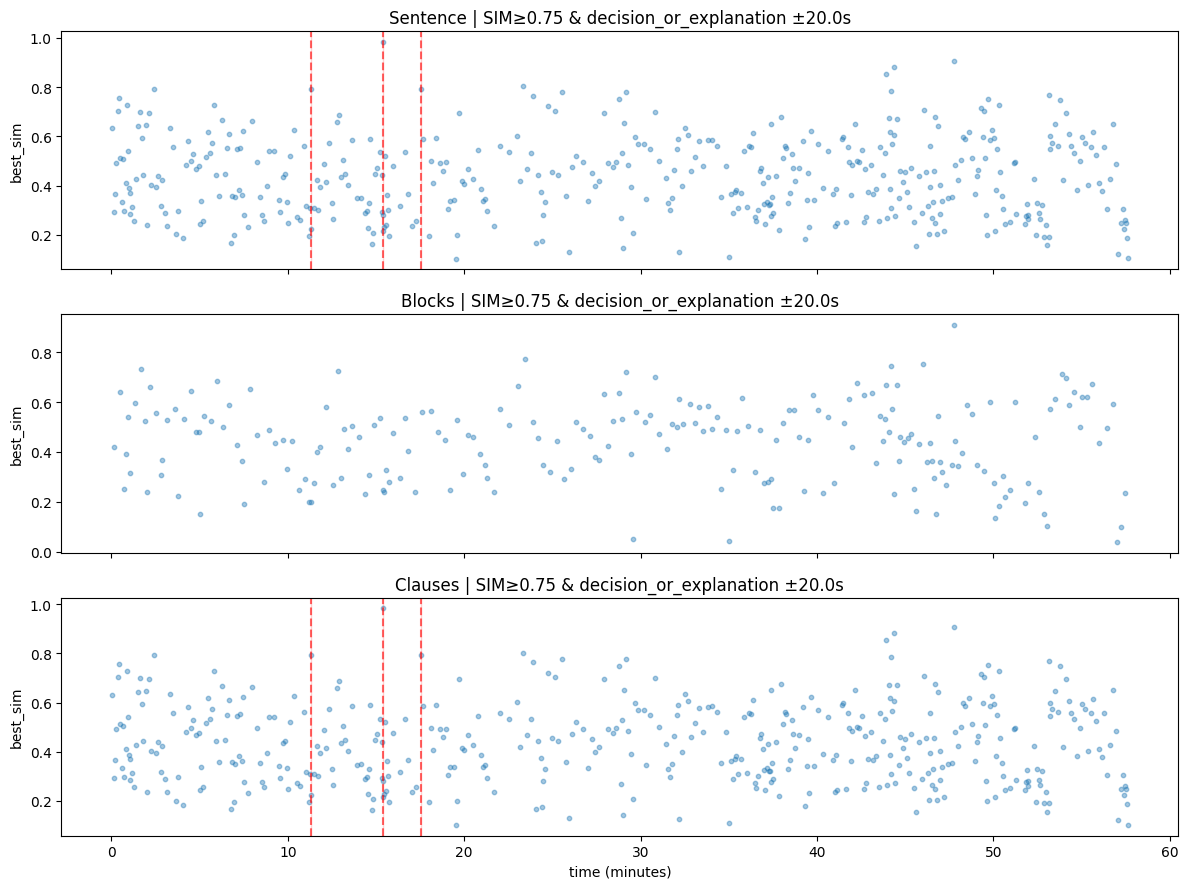

In [57]:
# === Decision- and Annotation-Gated Convergence Finder + Quick Plot =====================
import pandas as pd, numpy as np, os
from pathlib import Path
import matplotlib.pyplot as plt

# ---------------- Settings you can tweak -----------------------------------------------
SESSION_VAL           = "2021_05_21_ABI_S15"

# Similarity → events
SIM_THRESHOLD         = 0.75      # try 0.70–0.85; lower to see more candidates
EVENT_MERGE_GAP_SEC   = 10.0      # merge close event times into a single burst

# Label gate → what “counts”
GATE_MODE             = "decision_or_explanation"  
# options: "decision_only", "decision_or_explanation", "any_label", "keyword_only"

LABEL_WIN_SEC         = 20.0      # look for labels within ± this sec around event center
ROUND_TO_HALF         = True

# Data locations
UTTER_PATH = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv"
LENS_DIRS  = {
    "Sentence": "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sentence",
    "Blocks":   "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/blocks",
    "Clauses":  "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/clauses",
}
OUT_CSV    = f"/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_{GATE_MODE.upper()}.csv"

# ---------------- Helpers ----------------------------------------------------------------
def round_half(x):
    return (np.round(pd.to_numeric(x, errors="coerce") * 2) / 2.0)

def pick_edges_weight(df_edges: pd.DataFrame) -> str:
    if "weight" in df_edges.columns: return "weight"
    if "sim"    in df_edges.columns: return "sim"
    raise ValueError("edges_top_similar.csv needs a 'weight' or 'sim' column.")

def detect_bursts(times, gap=10.0):
    times = sorted(float(t) for t in times)
    out = []
    if not times: return out
    start = prev = times[0]
    for t in times[1:]:
        if t - prev <= gap: prev = t
        else:
            out.append((start, prev)); start = prev = t
    out.append((start, prev))
    return out

def to_boolish(v):
    if pd.isna(v): return False
    if isinstance(v, (int, float, np.integer, np.floating)): return float(v) != 0.0
    return str(v).strip().lower() in {"1","true","yes","y"}

def looks_like_decision_text(x: str) -> bool:
    if not isinstance(x, str) or not x.strip(): return False
    x = x.lower()
    keys = [
        "decide","decided","decision","we'll do","let's do","agreed","agree to",
        "consensus","conclude","finalize","put a pin","we will","we should","let us"
    ]
    return any(k in x for k in keys)

def looks_like_explanation_text(x: str) -> bool:
    if not isinstance(x, str) or not x.strip(): return False
    x = x.lower()
    keys = ["because","so that","in order to","therefore","thus","reason is","explain","explanation"]
    return any(k in x for k in keys)

def looks_like_new_idea_text(x: str) -> bool:
    if not isinstance(x, str) or not x.strip(): return False
    x = x.lower()
    keys = ["what if","we could","how about","another idea","new idea","propose","let's try"]
    return any(k in x for k in keys)

def passes_gate(row, mode: str):
    # use explicit tags if present, else keyword heuristics over annotations
    h_dec = to_boolish(row.get("has_decision"))
    h_exp = to_boolish(row.get("has_explanation"))
    h_new = to_boolish(row.get("has_new_idea"))
    ann   = row.get("annotations", "")

    k_dec = looks_like_decision_text(ann)
    k_exp = looks_like_explanation_text(ann)
    k_new = looks_like_new_idea_text(ann)

    if mode == "decision_only":
        return h_dec or k_dec
    if mode == "decision_or_explanation":
        return (h_dec or k_dec) or (h_exp or k_exp)
    if mode == "any_label":
        return (h_dec or h_exp or h_new) or (k_dec or k_exp or k_new)
    if mode == "keyword_only":
        return k_dec or k_exp or k_new
    return False

# ---------------- Load utterances + choose time columns ----------------------------------
u = pd.read_csv(UTTER_PATH)
uu = u[u["session"] == SESSION_VAL].copy()
if uu.empty:
    uu = u[u["session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()
if uu.empty:
    raise ValueError(f"No utterance rows match session='{SESSION_VAL}'")

time_col = "start_sec_adjusted" if "start_sec_adjusted" in uu.columns and uu["start_sec_adjusted"].notna().any() else "start_sec"
for c in [time_col, "global_timestamp_sec"]:
    if c in uu.columns: uu[c] = round_half(uu[c])
if "global_timestamp_sec" not in uu.columns:
    uu["global_timestamp_sec"] = uu[time_col]

for c in ["has_decision","has_explanation","has_new_idea","annotations","transcript","speaker"]:
    if c not in uu.columns:
        uu[c] = np.nan

# ---------------- Compute local→global offset from Sentence lens -------------------------
sent_t = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "timeline.csv"))
sent_e = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "edges_top_similar.csv"))
sent_t["t"] = round_half(sent_t["t"])
wcol = pick_edges_weight(sent_e)
hi_edges = sent_e[sent_e[wcol] >= SIM_THRESHOLD]
anchor_local = sent_t.set_index("u").reindex(hi_edges["source"])["t"].dropna().sort_values().tolist()

if anchor_local:
    t_anchor = float(anchor_local[0])
    j = (uu[time_col] - t_anchor).abs().idxmin()
    offset_sec = float(uu.loc[j, "global_timestamp_sec"] - uu.loc[j, time_col])
else:
    offset_sec = float(np.median(uu["global_timestamp_sec"] - uu[time_col]))

print(f"[INFO] Offset (local→global) ≈ {offset_sec:.3f}s | gate={GATE_MODE} | SIM≥{SIM_THRESHOLD} | ±{LABEL_WIN_SEC}s")

# ---------------- Collect events per lens + gate by labels --------------------------------
rows = []
for lens, folder in LENS_DIRS.items():
    t_path, e_path, n_path = [os.path.join(folder, f) for f in ("timeline.csv","edges_top_similar.csv","nodes.csv")]
    if not (os.path.exists(t_path) and os.path.exists(e_path) and os.path.exists(n_path)):
        print(f"[WARN] Missing files for {lens}; skipping.")
        continue

    df_t = pd.read_csv(t_path)
    df_e = pd.read_csv(e_path)
    df_n = pd.read_csv(n_path).rename(columns={"id":"unit_id"})

    df_t["t"] = round_half(df_t["t"])
    df_t["t_global"] = df_t["t"] + offset_sec
    if ROUND_TO_HALF: df_t["t_global"] = round_half(df_t["t_global"])

    # candidate high-sim events
    wcol = pick_edges_weight(df_e)
    cand = df_e[df_e[wcol] >= SIM_THRESHOLD].copy()
    if cand.empty: 
        continue

    # edge source → times; collapse to bursts
    u2tg = df_t.set_index("u")["t_global"]
    ev_times = u2tg.reindex(cand["source"]).dropna().tolist()
    bursts = detect_bursts(ev_times, gap=EVENT_MERGE_GAP_SEC)

    # filter by label window
    for (s_g, e_g) in bursts:
        c_g = 0.5*(s_g + e_g)
        m = (uu["global_timestamp_sec"] >= c_g - LABEL_WIN_SEC) & (uu["global_timestamp_sec"] <= c_g + LABEL_WIN_SEC)
        win = uu.loc[m].copy()
        if not len(win):
            continue
        # keep only if any row inside window passes the chosen gate
        if not any(passes_gate(r, GATE_MODE) for _, r in win.iterrows()):
            continue

        # nearest node for context
        idx = (df_t["t_global"] - c_g).abs().idxmin()
        unit_id = int(df_t.loc[idx, "u"]) if "u" in df_t.columns else None
        node = df_n[df_n["unit_id"] == unit_id]
        node_text = (node.iloc[0]["text"] if not node.empty and "text" in node.columns else "")
        node_speaker = (node.iloc[0]["speaker"] if not node.empty and "speaker" in node.columns else np.nan)

        # closest utterance inside window (for tags/annotation snapshot)
        k = (win["global_timestamp_sec"] - c_g).abs().idxmin()
        nearest = win.loc[k]

        rows.append({
            "lens": lens,
            "start_global_sec": float(s_g),
            "end_global_sec": float(e_g),
            "center_global_sec": float(c_g),
            "unit_id_center": unit_id,
            "node_speaker": node_speaker,
            "node_text": node_text,
            "nearest_speaker": nearest.get("speaker", np.nan),
            "nearest_time_global": float(nearest.get("global_timestamp_sec", np.nan)),
            "has_decision": nearest.get("has_decision", np.nan),
            "has_explanation": nearest.get("has_explanation", np.nan),
            "has_new_idea": nearest.get("has_new_idea", np.nan),
            "annotations": nearest.get("annotations", np.nan),
            "transcript": nearest.get("transcript", np.nan),
        })

events = pd.DataFrame(rows).sort_values(["lens","center_global_sec"]).reset_index(drop=True)
Path(os.path.dirname(OUT_CSV)).mkdir(parents=True, exist_ok=True)
events.to_csv(OUT_CSV, index=False)
print(f"✓ Wrote {OUT_CSV} (rows={len(events)})")
if len(events):
    preview = events.copy()
    preview["node_text"] = preview["node_text"].astype(str).str.slice(0,110)
    preview["transcript"] = preview["transcript"].astype(str).str.slice(0,110)
    print(preview.to_string(index=False))
else:
    print("No events passed the gate; try lowering SIM_THRESHOLD, widening LABEL_WIN_SEC, or switching GATE_MODE.")

# ---------------- Quick visual: timeline w/ convergence markers --------------------------
fig, axes = plt.subplots(len(LENS_DIRS), 1, figsize=(12, 9), sharex=True)
if len(LENS_DIRS) == 1: axes = [axes]

for ax, (lens, folder) in zip(axes, LENS_DIRS.items()):
    t_path = os.path.join(folder, "timeline.csv")
    if not os.path.exists(t_path): continue
    df_t = pd.read_csv(t_path)
    df_t["t_global"] = round_half(df_t["t"] + offset_sec)
    # base scatter
    ax.scatter(df_t["t_global"]/60, df_t["best_sim"], s=10, alpha=0.4, label="units")
    # overlay events we kept
    ev = events[events["lens"] == lens]
    for _, r in ev.iterrows():
        ax.axvspan(r["start_global_sec"]/60, r["end_global_sec"]/60, alpha=0.18, color="red")
        ax.axvline(r["center_global_sec"]/60, linestyle="--", alpha=0.6, color="red")
    ax.set_title(f"{lens} | SIM≥{SIM_THRESHOLD} & {GATE_MODE} ±{LABEL_WIN_SEC}s")
    ax.set_ylabel("best_sim")
axes[-1].set_xlabel("time (minutes)")
plt.tight_layout()
plt.show()
# =========================================================================================


In [58]:
for _, row in events.iterrows():
    print("\n" + "="*60)
    print(f"Lens: {row['lens']}, Center time: {row['center_global_sec']} sec")
    t0 = row['center_global_sec'] - 20
    t1 = row['center_global_sec'] + 20
    ctx = uu[(uu['global_timestamp_sec'] >= t0) & (uu['global_timestamp_sec'] <= t1)]
    for _, r in ctx.iterrows():
        print(f"[{r.global_timestamp_sec:.1f}s] {r.speaker}: {r.transcript}")



Lens: Clauses, Center time: 678.0 sec
[661.0s] Brad Smith: Maybe focus on your modality because I think when you get that's where we're going to be. Either your problem that you're trying to solve in deep tissue or the modality that you think you can bring to the problem.
[671.0s] Aniruddha Ray: Oh, there is Stephen Barbara. So Danny, can see you. Hey Danny.
[675.0s] Barbara Smith: Sorry, sorry. I have a little human that required me for a few minutes.
[682.0s] Aniruddha Ray: Um, so, uh, my name is Anirud. I'm from University of Toledo. I work on two different things. So I work on nanotechnology aided optical imaging, which involves fluorescence as well as photoacoustics. And that's what is my interest in deep tissue imaging. I also work on lensless holographic microscopy, um, but that is more for Xvivo samples or in vitro samples. So we basically develop different types of nanoparticles, um, metallic quantum dots, um, um, polymeric nanoparticles for biomedical imaging, sensing, as we

In [59]:
# === Verify decision-gated convergence events against transcript ===
WINDOW_SEC = 20  # seconds before/after event center

# Load utterances for session
uu_full = pd.read_csv(UTTER_PATH)
uu_full["global_timestamp_sec"] = pd.to_numeric(uu_full["global_timestamp_sec"], errors="coerce")

# Store output for review
all_event_contexts = []

for idx, row in events_decision.iterrows():
    center_time = row["center_global_sec"]
    start_win = center_time - WINDOW_SEC
    end_win = center_time + WINDOW_SEC
    
    # Filter utterances in the window
    context_rows = uu_full[
        (uu_full["global_timestamp_sec"] >= start_win) &
        (uu_full["global_timestamp_sec"] <= end_win) &
        (uu_full["session"].astype(str).str.contains(SESSION_VAL, na=False))
    ].copy()
    
    context_rows = context_rows[["global_timestamp_sec", "speaker", "transcript", "annotations"]]
    context_rows["event_id"] = idx  # tag which event it belongs to
    
    all_event_contexts.append(context_rows)
    
    # Print in notebook for quick check
    print(f"\n=== Event {idx} | Center @ {center_time:.1f}s ===")
    for _, c in context_rows.iterrows():
        print(f"[{c['global_timestamp_sec']:.1f}s] {c['speaker']}: {c['transcript']} | {c['annotations']}")

# Combine into one DataFrame
df_event_contexts = pd.concat(all_event_contexts, ignore_index=True)

# Save to CSV for spreadsheet review
OUT_CONTEXT_CSV = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_event_contexts.csv"
df_event_contexts.to_csv(OUT_CONTEXT_CSV, index=False)
print(f"\n✓ Saved event context snippets to {OUT_CONTEXT_CSV}")



=== Event 0 | Center @ 922.5s ===
[916.0s] Brad Smith: Uh see Shim. | {'encourage particpatioin': 'Brad Smith is inviting Shim to speak next and share their modality, continuing the round of introductions.'}
[917.0s] Sixian You: Hi everyone. My name is Sishan Yo. Uh, I recently started in electric engineering department at MIT. My background is in optics and microscopy. Uh, so, uh, we are very much troubled by deep tissue imaging because uh, we're we're blessed with this submicro resolution but we can rarely go deeper than millimeter uh depth. So what my lab does, uh, we want to tackle this issue and also a lot of other like imaging speed or contrast issue from three aspects. The first aspect is uh, um multiphoton imaging. | {'explain or define term or concept': 'The speaker is introducing themself and their background in optics and microscopy, providing context for their subsequent statements about deep tissue imaging.', 'present new idea': 'The speaker introduces the idea that their

Note: from this, this might not be a perfect example of true convergence - some of this is parallel brainstorming, topic expansion, or temporal over laps. 

### fixing convergence_event_contexts.csv 

Adding columns for True Convergence? and Notes (to mark them while reading transcript)

In [60]:
import pandas as pd
from pathlib import Path

# === Paths ===
input_path = Path("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_event_contexts.csv")
output_path = input_path.with_name("convergence_event_contexts_review.csv")

# === Load data ===
df = pd.read_csv(input_path)

# === Add review columns ===
df["label_convergence"] = ""       # Y / N / Maybe
df["label_type"] = ""              # e.g., agreement, paraphrase, decision, etc.
df["label_reason"] = ""            # short explanation
df["label_confidence_0to1"] = ""   # optional, e.g., 0.8

# === Optional: keep only relevant columns first ===
# If you want to reorder columns so labels appear at the front:
label_cols = ["label_convergence", "label_type", "label_reason", "label_confidence_0to1"]
df = df[label_cols + [c for c in df.columns if c not in label_cols]]

# === Save review CSV ===
df.to_csv(output_path, index=False)
print(f"✓ Wrote {output_path} (rows={len(df)})")


✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_event_contexts_review.csv (rows=36)


merging labels back into detected events 

(how many true vs. false by lens) and exporting final list of accepted convergence events for plots/reports

In [64]:
import pandas as pd
import numpy as np
from pathlib import Path

# === Paths (edit if needed) ===
EVENTS_DETECTED_CSV = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_DECISION_ONLY.csv"
REVIEW_CSV          = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_event_contexts_review.csv"
OUT_DIR             = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs"

CENTER_TOL_SEC = 2.0  # tolerance when matching by center time

# --- Load ---
det = pd.read_csv(EVENTS_DETECTED_CSV).copy()
rev = pd.read_csv(REVIEW_CSV).copy()

if "lens" not in det.columns or "center_global_sec" not in det.columns:
    raise ValueError("Detected events file must include 'lens' and 'center_global_sec'.")

# Normalize detected events
det["lens_norm"] = det["lens"].astype(str).str.strip().str.lower()
det["center_global_sec"] = pd.to_numeric(det["center_global_sec"], errors="coerce")

# --- Find/Build a label column in review ---
label_candidates = ["is_convergence", "verified", "keep", "label", "gold", "accept"]
label_cols = [c for c in label_candidates if c in rev.columns]

def to_binary_cell(x):
    if pd.isna(x): 
        return np.nan
    s = str(x).strip().lower()
    if s in {"1","true","t","yes","y","keep","accept","ok","okay"}: return 1
    if s in {"0","false","f","no","n","drop","reject"}: return 0
    try:
        return 1 if float(s) != 0 else 0
    except:
        return np.nan

if label_cols:
    LBL = label_cols[0]
    rev["label_bin"] = rev[LBL].apply(to_binary_cell)
else:
    # Try to infer from common comment fields
    hint_cols = [c for c in ["notes","note","comment","comments","review","tag"] if c in rev.columns]
    rev["label_bin"] = np.nan
    if hint_cols:
        def combine_and_bin(row):
            parts = []
            for c in hint_cols:
                v = row.get(c)
                if pd.notna(v):
                    parts.append(str(v))
            txt = " ".join(parts).strip().lower()
            if not txt: return np.nan
            pos = any(k in txt for k in ["yes","keep","true","accept","ok","okay","convergence","good","y"])
            neg = any(k in txt for k in ["no","reject","false","drop","n","not"])
            if pos and not neg: return 1
            if neg and not pos: return 0
            return np.nan
        rev["label_bin"] = rev.apply(combine_and_bin, axis=1)

    if rev["label_bin"].isna().all():
        print("⚠️  No explicit label found; defaulting all review rows to KEEP (1). "
              "Add a column like 'is_convergence' with yes/no to control this.")
        rev["label_bin"] = 1

# --- Supported review keys: event_id OR center_global_sec (± tol) (optional lens) ---
has_event_id  = "event_id" in rev.columns
has_center_ts = "center_global_sec" in rev.columns

if has_event_id:
    # Map event_id to (lens, center)
    if "event_id" in det.columns:
        det_idxmap = det[["event_id","lens","lens_norm","center_global_sec"]].copy()
    else:
        det_idxmap = det.reset_index().rename(columns={"index":"event_id"})[["event_id","lens","lens_norm","center_global_sec"]]
    rev_map = rev.merge(det_idxmap, on="event_id", how="left")
    if rev_map["center_global_sec"].isna().all():
        raise ValueError("Could not map review 'event_id' to detected events. Check ordering.")
    agg = (rev_map.groupby(["lens_norm","center_global_sec"], as_index=False)["label_bin"]
                 .max().rename(columns={"label_bin":"is_convergence"}))

elif has_center_ts:
    rev["center_global_sec"] = pd.to_numeric(rev["center_global_sec"], errors="coerce")
    if "lens" in rev.columns:
        rev["lens_norm"] = rev["lens"].astype(str).str.strip().str.lower()
    else:
        rev["lens_norm"] = "__any__"
    agg = (rev.groupby(["lens_norm","center_global_sec"], as_index=False)["label_bin"]
               .max().rename(columns={"label_bin":"is_convergence"}))
else:
    raise ValueError("Review file must contain either 'event_id' or 'center_global_sec' (optionally with 'lens').")

# --- Tolerant merge of labels back to detected events ---
def tolerant_time_merge(det_df, agg_df, tol=CENTER_TOL_SEC):
    det_sorted = det_df.sort_values("center_global_sec").copy()
    out = []
    for ln in det_sorted["lens_norm"].unique():
        L = det_sorted[det_sorted["lens_norm"]==ln].copy()
        # If the review didn't specify lens, allow matching from any lens
        R = agg_df if "__any__" in agg_df["lens_norm"].unique() else agg_df[agg_df["lens_norm"]==ln]
        if R.empty:
            L["is_convergence"] = np.nan
            out.append(L)
            continue
        L = L.sort_values("center_global_sec")
        R = R.sort_values("center_global_sec")
        merged = pd.merge_asof(
            L, R[["center_global_sec","is_convergence"]],
            on="center_global_sec", direction="nearest", tolerance=tol
        )
        out.append(merged)
    return pd.concat(out, ignore_index=True)

merged = tolerant_time_merge(det, agg, tol=CENTER_TOL_SEC)

# Fill missing as 0 but track missingness
merged["label_missing"] = merged["is_convergence"].isna()
merged["is_convergence"] = merged["is_convergence"].fillna(0).astype(int)

# --- Metrics & export ---
summary = (merged.groupby("lens", as_index=False)
                 .agg(n_events=("is_convergence","size"),
                      n_true=("is_convergence","sum"),
                      n_unlabeled=("label_missing","sum")))
summary["n_false"] = summary["n_events"] - summary["n_true"]

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
final_keep_path = str(Path(OUT_DIR) / "convergence_events_FINAL.csv")
final_drop_path = str(Path(OUT_DIR) / "convergence_events_REJECTED.csv")
report_path     = str(Path(OUT_DIR) / "convergence_events_METRICS.csv")

merged[merged["is_convergence"]==1].to_csv(final_keep_path, index=False)
merged[merged["is_convergence"]==0].to_csv(final_drop_path, index=False)
summary.to_csv(report_path, index=False)

print("✓ Wrote:")
print("  -", final_keep_path, f"(rows={len(merged[merged['is_convergence']==1])})")
print("  -", final_drop_path, f"(rows={len(merged[merged['is_convergence']==0])})")
print("  -", report_path)
print("\nQuick metrics:\n", summary.to_string(index=False))


⚠️  No explicit label found; defaulting all review rows to KEEP (1). Add a column like 'is_convergence' with yes/no to control this.
✓ Wrote:
  - /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_FINAL.csv (rows=2)
  - /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_REJECTED.csv (rows=0)
  - /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_METRICS.csv

Quick metrics:
     lens  n_events  n_true  n_unlabeled  n_false
 Clauses         1       1            0        0
Sentence         1       1            0        0


## Idea 3 - merge small speaker runs - unecessary?